# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

import optuna

from torchinfo import summary

from sklearn.inspection import permutation_importance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset and Dataloader Creation

In [2]:
import sys
print(sys.version)

3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


In [3]:
df = pd.read_csv("final_scaled_df.csv")   # Replace with your CSV file

df = df.drop(['hsi_id'], axis=1)

cols_to_drop = ['vomitoxin_ppb', 'mode', 'target_cluster', 'sensor_cluster', 'Anomaly'] # best
cols_to_drop = cols_to_drop + ['302', '258', '368', '327', '44', '346', '269', '354', '279',
       '314', '99', '420', '29', '292', '83', '254', '295', '263', '231',
       '243', '351', '6', '25', '248', '2', '350', '390', '13', '247',
       '85', '330', '443', '177', '160', '276', '31', '14', '94', '221',
       '92', '58', '306', '69', '316', '339', '373', '5', '81', '19',
       '15', '228', '234', '317', '321', '203', '436', '240', '55', '214',
       '187', '226', '84', '207', '355', '259', '277', '172', '419',
       '229', '357', '233', '291', '95', '288', '72', '383', '217', '79',
       '192', '105', '227', '137', '206', '150', '52', '264', '267',
       '304', '168', '224', '3', '7', '237', '186', '96', '379', '225',
       '133', '157', '104', '209', '245', '158', '148', '152', '201',
       '239', '167', '26', '164', '404', '132', '198', '271', '301', '93',
       '161', '169', '100', '174', '112', '204', '212', '359', '281',
       '166', '235', '238', '141', '268', '232', '162', '103', '208',
       '86', '154', '241', '274', '173', '10', '362', '107', '51', '143',
       '183', '219', '87', '252', '210', '244', '163', '216', '145',
       '193', '110', '146', '117', '123', '101', '223', '149', '184', '4',
       '114', '122', '236', '230', '97', '119', '147', '57', '127', '116',
       '59', '175', '118', '109', '205', '28', '12', '189', '185', '190',
       '142', '128', '215', '124', '182', '179', '125', '181', '222',
       '180', '151', '115', '131', '120', '144', '111', '200', '126',
       '73', '155', '138', '197', '165', '278', '308', '171', '108',
       '153', '106', '8', '130', '188', '250', '129', '156', '213', '170',
       '194', '140', '159', '134', '139', '121', '11', '195', '136',
       '113', '135', '102', '56']# slight decrease more or less same

cols_to_drop = cols_to_drop + ['298', '344', '47', '340', '421', '332', '286', '251', '41', '403',
       '349', '66', '415', '307', '328', '309', '303', '78', '313', '342',
       '34', '402', '261', '312', '273', '430', '367', '385', '305',
       '438', '386', '256', '293', '326', '375', '320', '384', '335',
       '387', '300', '374', '17', '211', '285', '257', '255', '220',
       '401', '334', '265', '90', '45', '262', '294', '369', '270', '88',
       '352', '242', '376', '196', '68', '289', '176', '253', '297',
       '199', '412', '22', '284', '266', '65', '246', '280', '272', '283',
       '311', '218', '178', '191', '338', '260', '282', '331', '202',
       '310', '287', '98' # Validation gets worse
        ] + ['43', '371', '348', '396', '62', '337', '89', '67', '405', '365',
            '53', '80', '329', '64', '16', '325', '361', '360', '347', '343',
            '391', '91', '364', '18', '353', '275', '345', '323', '324', '333',
            '341', '370', '363', '322', '356', '296', '319', '318', '249',
            '20', '299', '315' # completely worse

        ] + ['35', '372', '427', '413', '422', '414', '398', '426', '336','392', '388', '433', '418',
             '411', '409', '424' # train and test imporved but val has simillar problem
        
        ] + ['439', '38' # No validation improved
        
        ] + ['423', '406', '46', '410', '76', '395', '400', '407', '366', '416', '381', '358', '377', '378'# slightly improved
        
        ] + ['399', '380' # model Improved completely with less features
        
        ] + ['32', '49', '75', '30', '37'# slightly reduced but manageble
        ] + ['425', '431'] # all values are acceptable except one place at validation

        

X = df.drop(cols_to_drop, axis=1).values
y = df['vomitoxin_ppb'].values
cols = df.drop(cols_to_drop, axis=1).columns

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.02, random_state=42, shuffle = True)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, shuffle = True)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle = True)

# Custom Dataset Class
class CornDataset(Dataset):
    def __init__(self, numerical_data, targets):
        self.numerical_data = numerical_data
        self.targets = targets
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return {
            'numerical': self.numerical_data[idx],
            'target': self.targets[idx]
        }

# Create Datasets
train_dataset = CornDataset(X_train, y_train)
val_dataset = CornDataset(X_val, y_val)
test_dataset = CornDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

In [4]:
X_train.shape

torch.Size([380, 47])

In [5]:
print(f"Number of Batches in Train Loader: {len(train_loader)}")
print(f"Number of Batches in Val Loader: {len(val_loader)}")
print(f"Number of Batches in Test Loader: {len(test_loader)}")

Number of Batches in Train Loader: 12
Number of Batches in Val Loader: 3
Number of Batches in Test Loader: 1


In [6]:
for batch in train_loader:
    X_batch, y_batch = batch['numerical'], batch['target']
    print(f"Train Batch Shape: {X_batch.shape}, Target Shape: {y_batch.shape}")

Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Train Batch Shape: torch.Size([28, 47]), Target Shape: torch.Size([28, 1])


In [7]:
for batch in val_loader:
    X_batch, y_batch = batch['numerical'], batch['target']
    print(f"Val Batch Shape: {X_batch.shape}, Target Shape: {y_batch.shape}")

Val Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Val Batch Shape: torch.Size([32, 47]), Target Shape: torch.Size([32, 1])
Val Batch Shape: torch.Size([31, 47]), Target Shape: torch.Size([31, 1])


In [8]:
for batch in test_loader:
    X_batch, y_batch = batch['numerical'], batch['target']
    print(f"Test Batch Shape: {X_batch.shape}, Target Shape: {y_batch.shape}")

Test Batch Shape: torch.Size([25, 47]), Target Shape: torch.Size([25, 1])


In [9]:
print(f"Train Samples: {len(train_dataset)}")
print(f"Val Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

Train Samples: 380
Val Samples: 95
Test Samples: 25


# Baseline Model Creation

In [10]:
class DeepCornModel(nn.Module):
    def __init__(self, input_dim):
        super(DeepCornModel, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
#             nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.1),

            nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
#             nn.BatchNorm1d(32),
            nn.GELU(),
#             nn.Dropout(0.1),

            nn.Linear(32, 1)  # Output Layer
        )

    def forward(self, x):
        return self.network(x)
    
input_dim = X_train.shape[1]
model = torch.compile(DeepCornModel(input_dim).to(device), backend='eager')

In [11]:
class RMSELoss(nn.Module):
    def forward(self, y_pred, y_true):
        mse_loss = torch.mean((y_pred - y_true) ** 2)
        return torch.sqrt(mse_loss)

# criterion = nn.MSELoss()
criterion = RMSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)

# Training Model

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=500, patience=50):
    scaler = torch.amp.GradScaler()
    
    # Phase 1: Cosine Annealing (First 100 epochs)
    scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
    # Phase 2: ReduceLROnPlateau (Next 400 epochs)
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=patience)
    # Phase 3: Warm Restart (Last 50 epochs)
    scheduler3 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            X_batch = batch['numerical'].to(device)
            y_batch = batch['target'].to(device)

            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X_val_batch = batch['numerical'].to(device)
                y_val_batch = batch['target'].to(device)

                y_val_pred = model(X_val_batch)
                val_loss += criterion(y_val_pred, y_val_batch).item()

        val_loss_avg = val_loss/len(val_loader)
        print(f"Average Val Loss in Epoch {epoch+1} - {val_loss_avg}")
        
        # Dynamic Scheduler Switching
        if epoch <= 100:
            scheduler1.step()
            my_lr = scheduler1.get_last_lr()
            print(f"Learning Rate is rescheduled to {my_lr}")
        elif 100 < epoch <= 300:
            scheduler2.step(val_loss)
            my_lr = scheduler2.get_last_lr()
            print(f"Learning Rate is rescheduled to {my_lr}")
        else:
            scheduler3.step()
            my_lr = scheduler3.get_last_lr()
            print(f"Learning Rate is rescheduled to {my_lr}")
        
        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_deepcorn_model.pth')
        else:
            patience_counter += 1
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f} \n")

#         if patience_counter >= patience:
#             print("Early stopping triggered!")
#             break

In [13]:
if __name__ == "__main__":
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=300, patience = 20)

Average Val Loss in Epoch 1 - 12986.454345703125
Learning Rate is rescheduled to [0.009997535269026829]
Epoch 1/300 - Train Loss: 113062.017822 - Val Loss: 38959.363037 

Average Val Loss in Epoch 2 - 12644.450113932291
Learning Rate is rescheduled to [0.009990143508499217]
Epoch 2/300 - Train Loss: 105302.519043 - Val Loss: 37933.350342 

Average Val Loss in Epoch 3 - 11950.360188802084
Learning Rate is rescheduled to [0.009977832013192385]
Epoch 3/300 - Train Loss: 113030.805054 - Val Loss: 35851.080566 

Average Val Loss in Epoch 4 - 10846.343668619791
Learning Rate is rescheduled to [0.009960612933065818]
Epoch 4/300 - Train Loss: 102325.126953 - Val Loss: 32539.031006 

Average Val Loss in Epoch 5 - 10018.062255859375
Learning Rate is rescheduled to [0.009938503261272713]
Epoch 5/300 - Train Loss: 104230.780518 - Val Loss: 30054.186768 

Average Val Loss in Epoch 6 - 9209.142822265625
Learning Rate is rescheduled to [0.009911524817389801]
Epoch 6/300 - Train Loss: 87826.194336 - V

Average Val Loss in Epoch 49 - 5826.113199869792
Learning Rate is rescheduled to [0.005161896741595253]
Epoch 49/300 - Train Loss: 46632.574097 - Val Loss: 17478.339600 

Average Val Loss in Epoch 50 - 4040.83642578125
Learning Rate is rescheduled to [0.0050050000000000025]
Epoch 50/300 - Train Loss: 49163.480347 - Val Loss: 12122.509277 

Average Val Loss in Epoch 51 - 4236.05029296875
Learning Rate is rescheduled to [0.004848103258404752]
Epoch 51/300 - Train Loss: 47295.169922 - Val Loss: 12708.150879 

Average Val Loss in Epoch 52 - 4442.990397135417
Learning Rate is rescheduled to [0.004691361354951082]
Epoch 52/300 - Train Loss: 33258.417114 - Val Loss: 13328.971191 

Average Val Loss in Epoch 53 - 4698.086669921875
Learning Rate is rescheduled to [0.004534928974974023]
Epoch 53/300 - Train Loss: 26525.070557 - Val Loss: 14094.260010 

Average Val Loss in Epoch 54 - 4380.9697265625
Learning Rate is rescheduled to [0.004378960498346303]
Epoch 54/300 - Train Loss: 28840.967529 - Va

Average Val Loss in Epoch 98 - 4124.838460286458
Learning Rate is rescheduled to [1.985649150078357e-05]
Epoch 98/300 - Train Loss: 20830.570251 - Val Loss: 12374.515381 

Average Val Loss in Epoch 99 - 4130.074625651042
Learning Rate is rescheduled to [1.246473097317066e-05]
Epoch 99/300 - Train Loss: 18298.035889 - Val Loss: 12390.223877 

Average Val Loss in Epoch 100 - 4130.929361979167
Learning Rate is rescheduled to [1e-05]
Epoch 100/300 - Train Loss: 16794.360901 - Val Loss: 12392.788086 

Average Val Loss in Epoch 101 - 4131.179280598958
Learning Rate is rescheduled to [1.246473097317066e-05]
Epoch 101/300 - Train Loss: 19137.071350 - Val Loss: 12393.537842 

Average Val Loss in Epoch 102 - 4129.546142578125
Learning Rate is rescheduled to [1.246473097317066e-05]
Epoch 102/300 - Train Loss: 15674.744690 - Val Loss: 12388.638428 

Average Val Loss in Epoch 103 - 4126.070393880208
Learning Rate is rescheduled to [1.246473097317066e-05]
Epoch 103/300 - Train Loss: 19277.846497 - V

Average Val Loss in Epoch 146 - 4143.408610026042
Learning Rate is rescheduled to [1.246473097317066e-07]
Epoch 146/300 - Train Loss: 17825.797668 - Val Loss: 12430.225830 

Average Val Loss in Epoch 147 - 4143.394856770833
Learning Rate is rescheduled to [1.246473097317066e-07]
Epoch 147/300 - Train Loss: 19406.346436 - Val Loss: 12430.184570 

Average Val Loss in Epoch 148 - 4143.39208984375
Learning Rate is rescheduled to [1.246473097317066e-07]
Epoch 148/300 - Train Loss: 16173.493530 - Val Loss: 12430.176270 

Average Val Loss in Epoch 149 - 4143.40478515625
Learning Rate is rescheduled to [1.246473097317066e-07]
Epoch 149/300 - Train Loss: 20235.068176 - Val Loss: 12430.214355 

Average Val Loss in Epoch 150 - 4143.412109375
Learning Rate is rescheduled to [1.246473097317066e-07]
Epoch 150/300 - Train Loss: 18808.522217 - Val Loss: 12430.236328 

Average Val Loss in Epoch 151 - 4143.386311848958
Learning Rate is rescheduled to [1.246473097317066e-07]
Epoch 151/300 - Train Loss: 1

Average Val Loss in Epoch 194 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 194/300 - Train Loss: 20095.415771 - Val Loss: 12430.016113 

Average Val Loss in Epoch 195 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 195/300 - Train Loss: 19185.850830 - Val Loss: 12430.016113 

Average Val Loss in Epoch 196 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 196/300 - Train Loss: 17036.580139 - Val Loss: 12430.016113 

Average Val Loss in Epoch 197 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 197/300 - Train Loss: 17874.035217 - Val Loss: 12430.016113 

Average Val Loss in Epoch 198 - 4143.338623046875
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 198/300 - Train Loss: 16636.447998 - Val Loss: 12430.015869 

Average Val Loss in Epoch 199 - 4143.338623046875
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 199/300 - Train Lo

Average Val Loss in Epoch 243 - 4143.338623046875
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 243/300 - Train Loss: 20344.296936 - Val Loss: 12430.015869 

Average Val Loss in Epoch 244 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 244/300 - Train Loss: 27399.107666 - Val Loss: 12430.016113 

Average Val Loss in Epoch 245 - 4143.338623046875
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 245/300 - Train Loss: 18390.960999 - Val Loss: 12430.015869 

Average Val Loss in Epoch 246 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 246/300 - Train Loss: 18150.982300 - Val Loss: 12430.016113 

Average Val Loss in Epoch 247 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 247/300 - Train Loss: 14694.825500 - Val Loss: 12430.016113 

Average Val Loss in Epoch 248 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 248/300 - Train Lo

Average Val Loss in Epoch 291 - 4143.338785807292
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 291/300 - Train Loss: 18188.934143 - Val Loss: 12430.016357 

Average Val Loss in Epoch 292 - 4143.338785807292
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 292/300 - Train Loss: 16883.348022 - Val Loss: 12430.016357 

Average Val Loss in Epoch 293 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 293/300 - Train Loss: 19622.326050 - Val Loss: 12430.016113 

Average Val Loss in Epoch 294 - 4143.338785807292
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 294/300 - Train Loss: 22037.294189 - Val Loss: 12430.016357 

Average Val Loss in Epoch 295 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 295/300 - Train Loss: 17435.639221 - Val Loss: 12430.016113 

Average Val Loss in Epoch 296 - 4143.338704427083
Learning Rate is rescheduled to [1.246473097317066e-09]
Epoch 296/300 - Train Lo

# Testing Trained Baseline Model

In [14]:
input_dim = X_train.shape[1]
model = torch.compile(DeepCornModel(input_dim).to(device), backend='eager')
model.load_state_dict(torch.load('best_deepcorn_model.pth', weights_only=True))
model.eval()

def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

criterion = RMSELoss().to(device)

test_loss = 0.0
scaler = torch.amp.GradScaler()
i = 1

all_actuals = []
all_predictions = []

all_r2_scores = []
all_adjusted_r2 = []

with torch.no_grad():
    for batch in test_loader:
        test_loss_each_batch = 0
        
        X_test_batch = batch['numerical'].to(device)
        y_test_batch = batch['target'].to(device)
        
        y_test_pred = model(X_test_batch)
        
        all_actuals.append(y_test_batch.cpu().numpy())
        all_predictions.append(y_test_pred.cpu().numpy())
        
        if i == 1:
            print("Actual:", y_test_batch)
            print("Predicted:", y_test_pred)
        
        test_loss_each_batch = criterion(y_test_pred, y_test_batch).item()
        test_loss += test_loss_each_batch
        
        r2 = r2_score(y_test_batch.cpu().numpy(), y_test_pred.cpu().numpy())
        
        n_samples = X_test_batch.shape[0]
        n_features = X_test_batch.shape[1]
        adj_r2 = adjusted_r2_score(r2, n_samples, n_features)
        
        all_r2_scores.append(r2)
        all_adjusted_r2.append(adj_r2)

        print(f"Batch {i} RMSE: {test_loss_each_batch:.6f} | R2 Score: {r2:.6f} | Adjusted R2 Score: {adj_r2:.6f}")
        i += 1

test_loss /= len(test_loader)
avg_r2 = sum(all_r2_scores) / len(all_r2_scores)
avg_adj_r2 = sum(all_adjusted_r2) / len(all_adjusted_r2)

print(f"Average Test Loss (RMSE): {test_loss:.6f}")
print(f"Average R2 Score: {avg_r2:.6f}")
print(f"Average Adjusted R2 Score: {avg_adj_r2:.6f}")

Actual: tensor([[  160.],
        [  300.],
        [  500.],
        [    0.],
        [ 3800.],
        [  810.],
        [    0.],
        [86900.],
        [  900.],
        [ 1700.],
        [18100.],
        [  400.],
        [ 2800.],
        [ 3500.],
        [ 2500.],
        [  460.],
        [    0.],
        [  700.],
        [ 4800.],
        [   90.],
        [  630.],
        [  900.],
        [  100.],
        [    0.],
        [ 1300.]], device='cuda:0')
Predicted: tensor([[   966.5050],
        [   493.8904],
        [   803.2479],
        [   940.2766],
        [  1008.5829],
        [  1031.6729],
        [   723.5560],
        [112065.8906],
        [   503.9077],
        [  4557.9980],
        [  6950.9863],
        [   401.2402],
        [ 13181.0039],
        [  1683.4386],
        [   999.8954],
        [   716.7008],
        [   487.5837],
        [   824.4478],
        [  4458.9668],
        [   303.5258],
        [   694.9208],
        [   590.8818],
       

Average Residuals on test data -1007.5872802734375


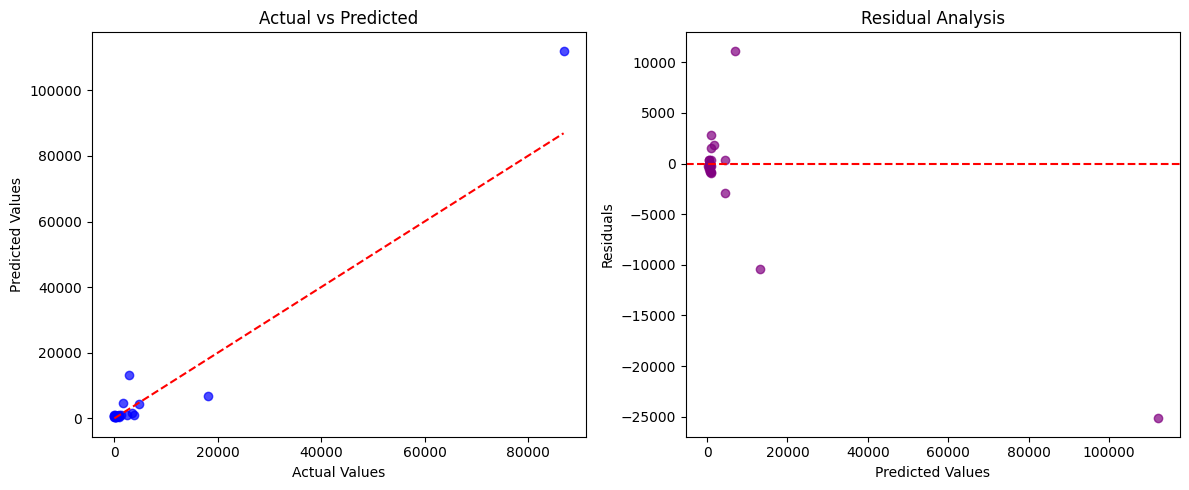

In [15]:
def plot_residuals_and_actual_vs_predicted(all_actuals, all_predictions, residuals):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(all_actuals, all_predictions, color='blue', alpha=0.7)
    plt.plot([min(all_actuals), max(all_actuals)], [min(all_actuals), max(all_actuals)], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')

    plt.subplot(1, 2, 2)
    plt.scatter(all_predictions, residuals, color='purple', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Analysis')

    plt.tight_layout()
    plt.show()

all_actuals = np.concatenate(all_actuals)
all_predictions = np.concatenate(all_predictions)

residuals = all_actuals - all_predictions

print(f"Average Residuals on test data {np.mean(residuals)}")

plot_residuals_and_actual_vs_predicted(all_actuals, all_predictions, residuals)

# Hyperparameter Tuning of our Awesome DeepCornModel

In [16]:
class DeepCornModelV2(nn.Module):
    def __init__(self, input_dim, hidden_units, num_layers, dropout_rate):
        super(DeepCornModelV2, self).__init__()

        layers = []
        in_features = input_dim
        
        for _ in range(num_layers):
            out_features = hidden_units
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class RMSELoss(nn.Module):
    def forward(self, y_pred, y_true):
        mse_loss = torch.mean((y_pred - y_true) ** 2)
        return torch.sqrt(mse_loss)


def objective(trial):
    num_layers = trial.suggest_int('num_layers', 3, 6)
    hidden_units = trial.suggest_int('hidden_units', 16, 512)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW'])
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle = True)
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = DeepCornModelV2(input_dim, hidden_units, num_layers, dropout_rate).to(device)

    criterion = RMSELoss()

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = 150
    
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X_val_batch, y_val_batch = batch
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch)
                val_loss += criterion(y_val_pred, y_val_batch).item()
        
        val_loss /= len(val_loader)

        # Report to Optuna
        trial.report(val_loss, epoch)

        # Early Stopping Condition
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

# if __name__ == "__main__":
#     study = optuna.create_study(study_name='Deep learning Model Optimization', direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
#                                )
#     study.optimize(objective, n_trials=200, n_jobs=-1)

#     print("Best Hyperparameters:", study.best_trial.params)

In [17]:
# Best - {3499.9847412109375} : {'num_layers': 5, 'hidden_units': 394, 'dropout_rate': 0.18246644101751114, 'learning_rate': 0.002970738988563734, 'weight_decay': 5.3684719482717085e-06, 'batch_size': 64, 'optimizer': 'AdamW'}
# {2875.1851806640625} : {'num_layers': 5, 'hidden_units': 434, 'dropout_rate': 0.10145295771212678, 'learning_rate': 0.003618876311494835, 'weight_decay': 0.0003619004957183076, 'batch_size': 64, 'optimizer': 'Adam'}
# Second Best - {3066.1258544921875} : {'num_layers': 4, 'hidden_units': 447, 'dropout_rate': 0.15263690651041537, 'learning_rate': 0.008482769443988571, 'weight_decay': 5.156093381421435e-05, 'batch_size': 64, 'optimizer': 'Adam'}
# {2884.8995361328125} : {'num_layers': 6, 'hidden_units': 504, 'dropout_rate': 0.14234726670552483, 'learning_rate': 0.00490944956011229, 'weight_decay': 1.4702174483896643e-05, 'batch_size': 64, 'optimizer': 'Adam'}
# {2852.1199951171875} : {'num_layers': 5, 'hidden_units': 473, 'dropout_rate': 0.19390575274453534, 'learning_rate': 0.0033419040382013693, 'weight_decay': 1.0716597519578205e-06, 'batch_size': 64, 'optimizer': 'AdamW'}
# {3496.8455810546875} : {'num_layers': 6, 'hidden_units': 465, 'dropout_rate': 0.2514688980998818, 'learning_rate': 0.0018781881431191938, 'weight_decay': 0.0008861998904193339, 'batch_size': 64, 'optimizer': 'Adam'}

# One of the best - {3480.35302734375} : {'num_layers': 4, 'hidden_units': 485, 'dropout_rate': 0.40767236375600413, 'learning_rate': 0.004279965492706501, 'weight_decay': 0.000668334597386981, 'batch_size': 64, 'optimizer': 'AdamW'}

# Training and Testing Hyperparameterized Our DeepCornModel

In [18]:
class DeepCornModelV2(nn.Module):
    def __init__(self, input_dim, hidden_units, num_layers, dropout_rate):
        super(DeepCornModelV2, self).__init__()

        layers = []
        in_features = input_dim
        
        # Dynamically create network with Optuna
        for _ in range(num_layers):
            out_features = hidden_units
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = out_features

        # Output Layer
        layers.append(nn.Linear(in_features, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_model(model, optimizer, criterion, train_loader, val_loader, scheduler=None, epochs=300):
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch['numerical'].to(device), batch['target'].to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        if scheduler:
            scheduler.step()
    
    return model

def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X_batch, y_batch = batch['numerical'].to(device), batch['target'].to(device)

            y_hat = model(X_batch)
            y_true.append(y_batch.cpu())
            y_pred.append(y_hat.cpu())
    
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    
    residuals = y_true - y_pred
    avg_residuals = np.mean(residuals)
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    n = len(y_true)
    p = X_batch.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'Adjusted R2 Score': adjusted_r2,
        'Avg Residuals': avg_residuals,
        'y_true': [y_true],
        'y_pred': [y_pred],
        'Residuals': [residuals],
    }

In [19]:
# best_params = study.best_trial.params
# best_params = {'num_layers': 5, 'hidden_units': 394, 'dropout_rate': 0.18246644101751114, 'learning_rate': 0.002970738988563734, 'weight_decay': 5.3684719482717085e-06, 'batch_size': 64, 'optimizer': 'AdamW'}
best_params = {'num_layers': 4, 'hidden_units': 485, 'dropout_rate': 0.40767236375600413, 'learning_rate': 0.004279965492706501, 'weight_decay': 0.000668334597386981, 'batch_size': 64, 'optimizer': 'AdamW'}
best_model = DeepCornModelV2(
    input_dim=input_dim,
    hidden_units=best_params['hidden_units'],
    num_layers=best_params['num_layers'],
    dropout_rate=best_params['dropout_rate']
).to(device)

optimizer = getattr(torch.optim, best_params['optimizer'])(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

criterion = RMSELoss()

In [20]:
summary(best_model, input_size=(X_train.shape[1],))

Layer (type:depth-idx)                   Output Shape              Param #
DeepCornModelV2                          [1]                       --
├─Sequential: 1-1                        [1]                       --
│    └─Linear: 2-1                       [485]                     23,280
│    └─GELU: 2-2                         [485]                     --
│    └─Dropout: 2-3                      [485]                     --
│    └─Linear: 2-4                       [485]                     235,710
│    └─GELU: 2-5                         [485]                     --
│    └─Dropout: 2-6                      [485]                     --
│    └─Linear: 2-7                       [485]                     235,710
│    └─GELU: 2-8                         [485]                     --
│    └─Dropout: 2-9                      [485]                     --
│    └─Linear: 2-10                      [485]                     235,710
│    └─GELU: 2-11                        [485]                    

In [21]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

best_model = train_model(best_model, optimizer, criterion, train_loader, val_loader, scheduler, epochs=300)

In [22]:
train_metrics = evaluate_model(best_model, train_loader)
val_metrics = evaluate_model(best_model, val_loader)
test_metrics = evaluate_model(best_model, test_loader)

In [23]:
print("Train Metrics:")
display(pd.DataFrame(train_metrics))
print("Validation Metrics:")
display(pd.DataFrame(val_metrics))
print("Test Metrics:") 
display(pd.DataFrame(test_metrics))

Train Metrics:


,MAE,MSE,RMSE,R2 Score,Adjusted R2 Score,Avg Residuals,y_true,y_pred,Residuals
0,516.018738,731064.6875,855.023193,0.995182,0.9945,200.334412,"[[200.0], [500.0], [600.0], [200.0], [3100.0],...","[[108.10738], [312.5241], [318.0856], [395.584...","[[91.89262], [187.47589], [281.9144], [-195.58..."


Validation Metrics:


,MAE,MSE,RMSE,R2 Score,Adjusted R2 Score,Avg Residuals,y_true,y_pred,Residuals
0,2165.349609,16961900.0,4118.48291,0.921073,0.842146,1488.120239,"[[0.0], [100.0], [2000.0], [6700.0], [3600.0],...","[[1172.7511], [263.95587], [4590.037], [603.85...","[[-1172.7511], [-163.95587], [-2590.037], [609..."


Test Metrics:


,MAE,MSE,RMSE,R2 Score,Adjusted R2 Score,Avg Residuals,y_true,y_pred,Residuals
0,1209.527466,3689019.0,1920.681885,0.987299,1.013253,226.294693,"[[160.0], [300.0], [500.0], [0.0], [3800.0], [...","[[435.91983], [348.14954], [419.22058], [326.9...","[[-275.91983], [-48.149536], [80.77942], [-326..."


Training Plot


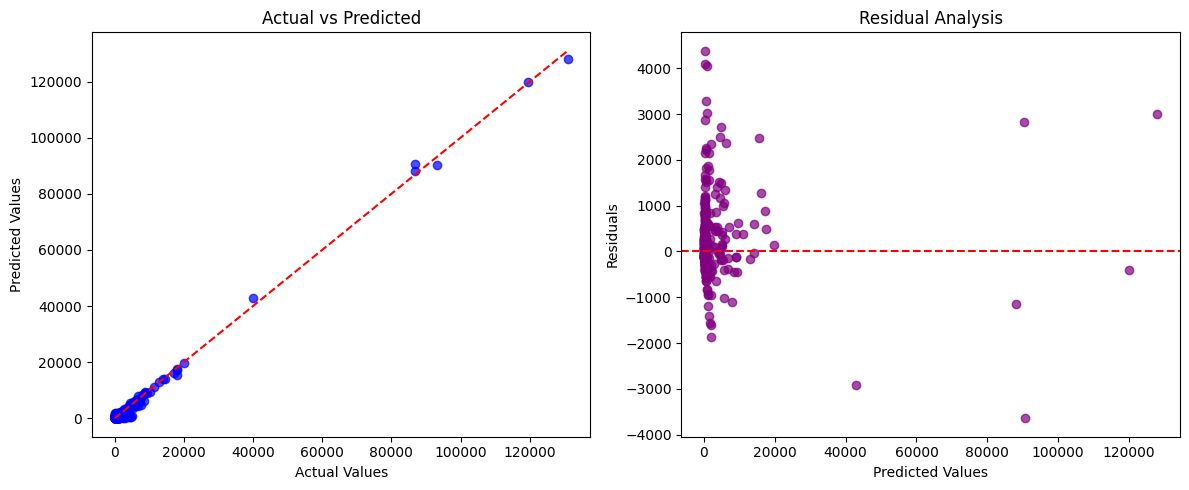

Validation Plot


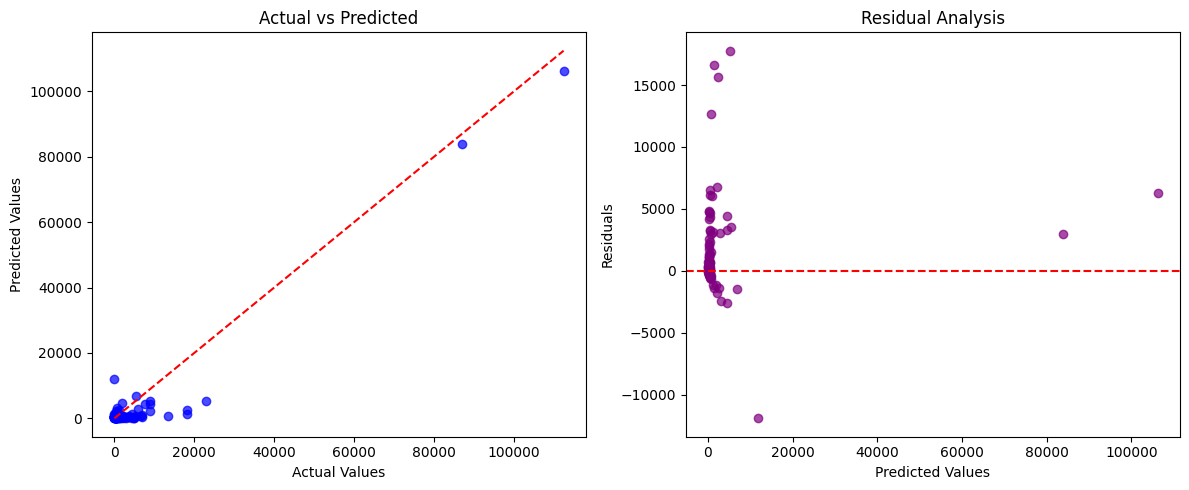

Testing Plot


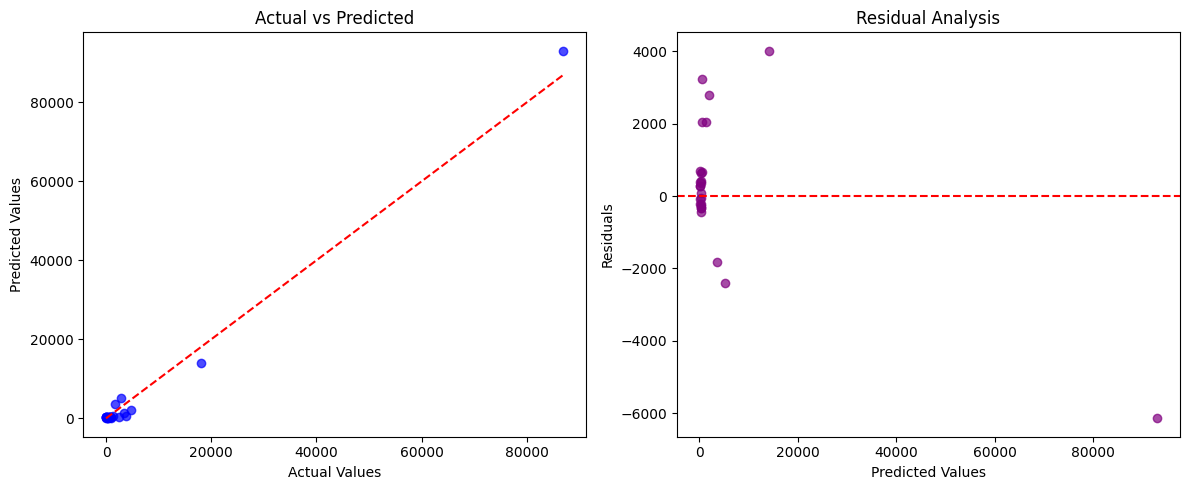

In [24]:
print('Training Plot')
plot_residuals_and_actual_vs_predicted(np.concatenate(np.concatenate(train_metrics['y_true'])), np.concatenate(np.concatenate(train_metrics['y_pred'])), np.concatenate(np.concatenate(train_metrics['Residuals'])))
print('Validation Plot')
plot_residuals_and_actual_vs_predicted(np.concatenate(np.concatenate(val_metrics['y_true'])), np.concatenate(np.concatenate(val_metrics['y_pred'])), np.concatenate(np.concatenate(val_metrics['Residuals'])))
print('Testing Plot')
plot_residuals_and_actual_vs_predicted(np.concatenate(np.concatenate(test_metrics['y_true'])), np.concatenate(np.concatenate(test_metrics['y_pred'])), np.concatenate(np.concatenate(test_metrics['Residuals'])))

# Cross Validation on Deep Corn Model

In [25]:
def cross_validate_model(kfold, X_train_val, y_train_val, X_test, y_test, best_params, epochs, device):
    results_df = pd.DataFrame(columns=[ 
        "Fold", "Train MAE", "Train MSE", "Train RMSE", "Train R2 Score", "Train Adjusted R2 Score", 
        "Val MAE", "Val MSE", "Val RMSE", "Val R2 Score", "Val Adjusted R2 Score", 
        "Test MAE", "Test MSE", "Test RMSE", "Test R2 Score", "Test Adjusted R2 Score",
        "Train Avg Residuals", "Val Avg Residuals", "Test Avg Residuals",
        "Train y_true", "Train y_pred", "Train Residuals",
        "Val y_true", "Val y_pred", "Val Residuals",
        "Test y_true", "Test y_pred", "Test Residuals"
    ])

    fold = 1
    for train_idx, val_idx in kfold.split(X_train_val):
        print(f"Training fold {fold}...")

        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        train_dataset = CornDataset(X_train, y_train)
        val_dataset = CornDataset(X_val, y_val)
        test_dataset = CornDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], pin_memory=True)

        best_model = DeepCornModelV2(
            input_dim=X_train.shape[1],
            hidden_units=best_params['hidden_units'],
            num_layers=best_params['num_layers'],
            dropout_rate=best_params['dropout_rate']
        ).to(device)

        optimizer = getattr(optim, best_params['optimizer'])( 
            best_model.parameters(),
            lr=best_params['learning_rate'],
            weight_decay=best_params['weight_decay']
        )
        criterion = RMSELoss()

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

        for epoch in range(epochs):
            best_model.train()
            running_loss = 0.0

            for batch in train_loader:
                inputs = batch['numerical'].to(device)
                targets = batch['target'].to(device)

                optimizer.zero_grad()
                outputs = best_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            scheduler.step()

        train_metrics = evaluate_model(best_model, train_loader)
        val_metrics = evaluate_model(best_model, val_loader)
        test_metrics = evaluate_model(best_model, test_loader)

        new_result = pd.DataFrame([{
            "Fold": fold,
            "Train MAE": train_metrics['MAE'],
            "Train MSE": train_metrics['MSE'],
            "Train RMSE": train_metrics['RMSE'],
            "Train R2 Score": train_metrics['R2 Score'],
            "Train Adjusted R2 Score": train_metrics['Adjusted R2 Score'],
            "Val MAE": val_metrics['MAE'],
            "Val MSE": val_metrics['MSE'],
            "Val RMSE": val_metrics['RMSE'],
            "Val R2 Score": val_metrics['R2 Score'],
            "Val Adjusted R2 Score": val_metrics['Adjusted R2 Score'],
            "Test MAE": test_metrics['MAE'],
            "Test MSE": test_metrics['MSE'],
            "Test RMSE": test_metrics['RMSE'],
            "Test R2 Score": test_metrics['R2 Score'],
            "Test Adjusted R2 Score": test_metrics['Adjusted R2 Score'],
            "Train Avg Residuals": train_metrics['Avg Residuals'],
            "Val Avg Residuals": val_metrics['Avg Residuals'],
            "Test Avg Residuals": test_metrics['Avg Residuals'],
            "Train y_true": train_metrics['y_true'],
            "Train y_pred": train_metrics['y_pred'],
            "Train Residuals": train_metrics['Residuals'],
            "Val y_true": val_metrics['y_true'],
            "Val y_pred": val_metrics['y_pred'],
            "Val Residuals": val_metrics['Residuals'],
            "Test y_true": test_metrics['y_true'],
            "Test y_pred": test_metrics['y_pred'],
            "Test Residuals": test_metrics['Residuals']
        }])

        results_df = pd.concat([results_df, new_result], ignore_index=True)

#         print(f"Fold {fold} - Train Metrics: {train_metrics}")
#         print(f"Fold {fold} - Val Metrics: {val_metrics}")
#         print(f"Fold {fold} - Test Metrics: {test_metrics}")
        
        print(f"Completed fold {fold}.")
        fold += 1

    return results_df

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 200

print("Cross-validation Begins\n")
results = cross_validate_model(kfold, X_train_val, y_train_val, X_test, y_test, best_params, epochs, device)
print("\nCross-validation Ends")

Cross-validation Begins

Training fold 1...
Completed fold 1.
Training fold 2...
Completed fold 2.
Training fold 3...
Completed fold 3.
Training fold 4...
Completed fold 4.
Training fold 5...
Completed fold 5.

Cross-validation Ends


In [26]:
pd.set_option('display.max_columns', None)
display(results)
pd.reset_option('display.max_columns')

numeric_results = results.drop(columns=["Fold"])
average_results = numeric_results.mean(numeric_only = True)

n_splits = kfold.get_n_splits()
average_results["AverageofNoOfFold"] = n_splits

average_results_df = pd.DataFrame(average_results).transpose()

average_results_df = average_results_df[["AverageofNoOfFold"] + [col for col in average_results_df.columns if col != "AverageofNoOfFold"]]

print("\nAverage Metrics Across Folds:")
pd.set_option('display.max_columns', None)
display(average_results_df)
pd.reset_option('display.max_columns')

,Fold,Train MAE,Train MSE,Train RMSE,Train R2 Score,Train Adjusted R2 Score,Val MAE,Val MSE,Val RMSE,Val R2 Score,Val Adjusted R2 Score,Test MAE,Test MSE,Test RMSE,Test R2 Score,Test Adjusted R2 Score,Train Avg Residuals,Val Avg Residuals,Test Avg Residuals,Train y_true,Train y_pred,Train Residuals,Val y_true,Val y_pred,Val Residuals,Test y_true,Test y_pred,Test Residuals
0,1,1193.864990,9672779.0,3110.109131,0.936252,0.927227,2621.558350,35082424.0,5923.041992,0.836755,0.673509,1676.566284,12572406.0,3545.758789,0.956715,1.045167,627.891418,1945.069946,1244.260132,"[[[760.0], [1600.0], [200.0], [700.0], [0.0], ...","[[[322.53513], [195.60437], [527.09546], [1653...","[[[437.46487], [1404.3956], [-327.09546], [-95...","[[[1300.0], [2000.0], [0.0], [300.0], [380.0],...","[[[107.60674], [668.42346], [522.76263], [674....","[[[1192.3933], [1331.5765], [-522.76263], [-37...","[[[160.0], [300.0], [500.0], [0.0], [3800.0], ...","[[[597.94934], [339.6432], [495.64136], [963.7...","[[[-437.94934], [-39.64319], [4.3586426], [-96..."
1,2,1054.539429,4549957.5,2133.062988,0.969408,0.965077,2340.770508,31817052.0,5640.660645,0.860671,0.721342,1385.858154,6287950.5,2507.578613,0.978352,1.022590,110.987480,350.047791,54.821449,"[[[1100.0], [400.0], [850.0], [1300.0], [7000....","[[[400.89795], [576.4154], [214.41515], [2922....","[[[699.10205], [-176.4154], [635.58484], [-162...","[[[1000.0], [80.0], [0.0], [500.0], [0.0], [0....","[[[785.6307], [311.74185], [885.5128], [499.57...","[[[214.36932], [-231.74185], [-885.5128], [0.4...","[[[160.0], [300.0], [500.0], [0.0], [3800.0], ...","[[[373.96356], [914.39386], [343.24423], [566....","[[[-213.96356], [-614.39386], [156.75577], [-5..."
2,3,1263.538696,5104075.0,2259.219971,0.974843,0.971282,2075.007324,22684592.0,4762.834473,-1.803702,-4.607405,1468.458618,7192955.0,2681.968506,0.975236,1.025841,315.650696,-959.424316,-188.562134,"[[[8900.0], [650.0], [7500.0], [270.0], [130.0...","[[[6904.8906], [598.0902], [3886.252], [318.14...","[[[1995.1094], [51.90979], [3613.748], [-48.14...","[[[3500.0], [1000.0], [0.0], [400.0], [0.0], [...","[[[184.92262], [752.1358], [764.1408], [429.30...","[[[3315.0774], [247.8642], [-764.1408], [-29.3...","[[[160.0], [300.0], [500.0], [0.0], [3800.0], ...","[[[1412.782], [680.48645], [625.1482], [1421.1...","[[[-1252.782], [-380.48645], [-125.14819], [-1..."
3,4,942.874023,2426627.0,1557.763428,0.984785,0.982631,2208.383057,22507978.0,4744.257324,0.878264,0.756528,2220.762939,22833966.0,4778.489746,0.921386,1.082032,157.180984,506.148468,-9.404204,"[[[3700.0], [0.0], [850.0], [100.0], [200.0], ...","[[[1518.7479], [774.2293], [307.44693], [414.4...","[[[2181.252], [-774.2293], [542.5531], [-314.4...","[[[90.0], [200.0], [6300.0], [500.0], [400.0],...","[[[847.38684], [988.9346], [1353.7897], [472.0...","[[[-757.38684], [-788.9346], [4946.2104], [27....","[[[160.0], [300.0], [500.0], [0.0], [3800.0], ...","[[[1956.8799], [431.8992], [436.18854], [487.0...","[[[-1796.8799], [-131.8992], [63.811462], [-48..."
4,5,1170.277832,7355752.5,2712.149170,0.954108,0.947611,1866.136719,25067178.0,5006.713379,0.862311,0.724623,1667.400269,13166104.0,3628.512695,0.954671,1.047300,307.793823,606.943298,-631.589661,"[[[500.0], [0.0], [1900.0], [300.0], [500.0], ...","[[[1099.6943], [355.47552], [610.1807], [36.72...","[[[-599.69434], [-355.47552], [1289.8193], [26...","[[[570.0], [2100.0], [200.0], [200.0], [2700.0...","[[[96.03613], [443.20163], [300.55453], [1564....","[[[473.96387], [1656.7983], [-100.554535], [-1...","[[[160.0], [300.0], [500.0], [0.0], [3800.0], ...","[[[458.3358], [1747.2178], [399.67838], [724.0...","[[[-298.3358], [-1447.2178], [100.321625], [-7..."



Average Metrics Across Folds:


,AverageofNoOfFold,Train MAE,Train MSE,Train RMSE,Train R2 Score,Train Adjusted R2 Score,Val MAE,Val MSE,Val RMSE,Val R2 Score,Val Adjusted R2 Score,Test MAE,Test MSE,Test RMSE,Test R2 Score,Test Adjusted R2 Score,Train Avg Residuals,Val Avg Residuals,Test Avg Residuals
0,5.0,1125.018921,5821838.5,2354.460938,0.963879,0.958766,2222.371338,27431844.0,5215.501465,0.32686,-0.346281,1683.809204,12410677.0,3428.46167,0.957272,1.044586,303.900879,489.757019,93.905113


# Visualizations of CV Results on Train, Validation, Test

### Metric Analysis

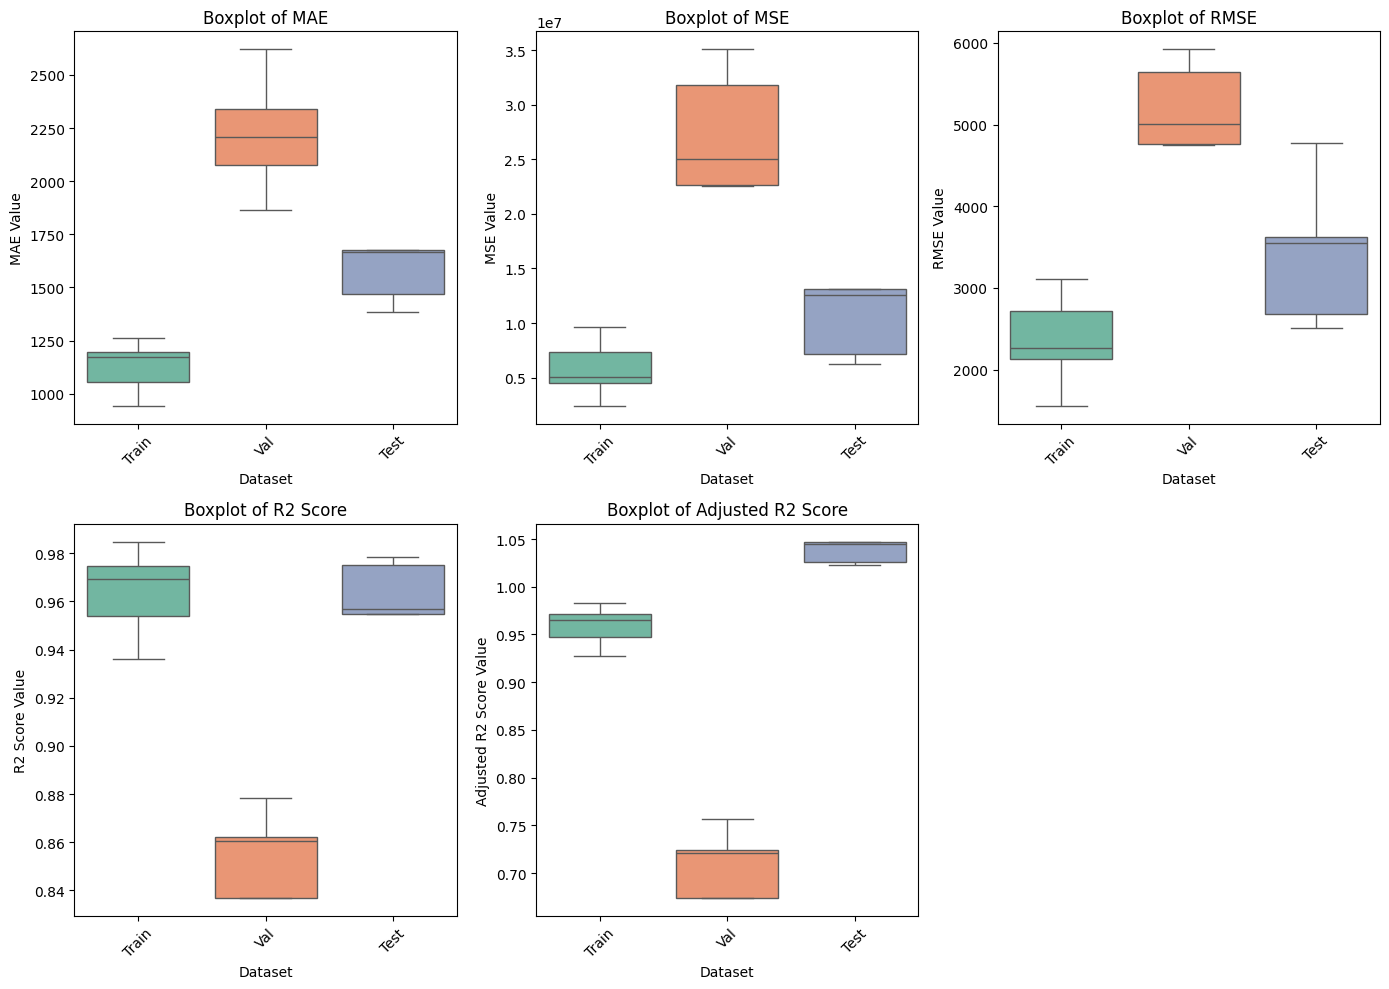

In [27]:
# Boxplot for MAE, MSE, RMSE, R2, Adjusted R2:

# Create boxplots for each metric (MAE, MSE, RMSE, etc.) across different folds to see the distribution and how consistent your model is. You can do this for training, validation, and testing separately.
# This can help you identify outliers, which folds are performing exceptionally well or poorly, and overall model stability.

# Insights to Look For:
# Consistency: If the boxplots for Train, Val, and Test datasets show similar distributions, this indicates that your model is consistent across different datasets and doesn't overfit.

# Overfitting: If the Train dataset has a much better performance (lower MAE, MSE, RMSE, higher R2, etc.) than the Validation and Test datasets, this suggests that the model is overfitting.
# Underfitting: If all datasets show poor performance (high MAE, MSE, RMSE, low R2), the model might be too simple or not capturing enough complexity from the data.
# Outliers:

# If there are many outliers in the Test or Validation sets, this suggests that the model is struggling to predict certain instances accurately. Investigating the outliers in these datasets might reveal problematic data points or issues with the model.
# Distribution Spread:

# A wide box or long whiskers in the Validation and Test datasets suggest high variability in the model's performance across folds. A more consistent spread would indicate a stable model.
# Model Performance Across Folds:

# If the folds (represented on the x-axis) have very different boxplot shapes, it indicates that the model's performance varies widely across different splits. This could be due to the data distribution in each fold or inherent instability in the model.

metrics = ['MAE', 'MSE', 'RMSE', 'R2 Score', 'Adjusted R2 Score']

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    
    df_long = pd.DataFrame()
    for dataset in ['Train', 'Val', 'Test']:
        metric_name = f"{dataset} {metric}"
        temp_df = pd.DataFrame({
            'Fold': results['Fold'],
            'Metric': metric,
            'Dataset': dataset,
            'Value': results[metric_name]
        })
        df_long = pd.concat([df_long, temp_df], ignore_index=True)
        
    sns.boxplot(data=df_long, x='Dataset', y='Value', hue='Dataset', palette="Set2", showfliers=False)
    
    plt.title(f"Boxplot of {metric}")
    plt.xlabel("Dataset")
    plt.ylabel(f"{metric} Value")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

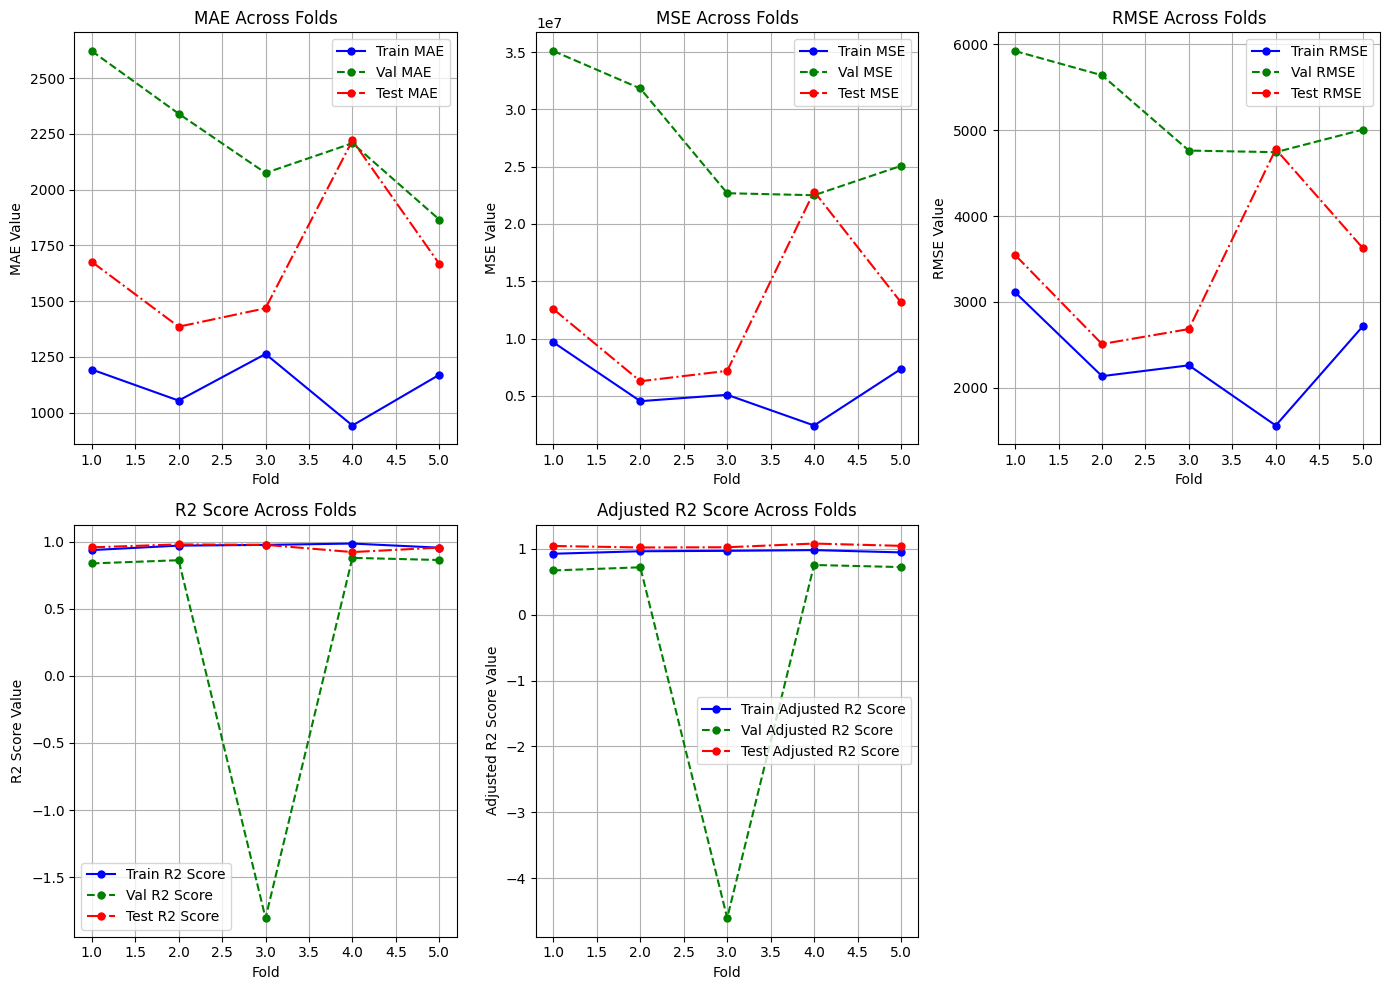

In [28]:
# Line Plot for MAE, MSE, RMSE, R2, Adjusted R2 Across Folds:

# Plot these metrics across the folds to track performance over time. This is useful to spot trends, like if the model improves or worsens with more folds.
# Separate the lines for training, validation, and testing to understand how generalizable your model is.

# Insights to Look For:
# Trends: Are there any patterns in the model's performance? For example, does the performance improve with more folds, or does it fluctuate?
# Overfitting or Underfitting: If the training performance is significantly better than the validation and test performances across folds, it could indicate overfitting. If all performance metrics are low for all datasets, the model might be underfitting.
# Stability: A stable model should show consistent performance across folds for all datasets. Large fluctuations could indicate instability in the model's ability to generalize.

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)  
    
    plt.plot(results['Fold'], results[f"Train {metric}"], label=f"Train {metric}", marker='o', color='blue', linestyle='-', markersize=5)
    plt.plot(results['Fold'], results[f"Val {metric}"], label=f"Val {metric}", marker='o', color='green', linestyle='--', markersize=5)
    plt.plot(results['Fold'], results[f"Test {metric}"], label=f"Test {metric}", marker='o', color='red', linestyle='-.', markersize=5)
    
    plt.title(f"{metric} Across Folds")
    plt.xlabel("Fold")
    plt.ylabel(f"{metric} Value")
    plt.legend(loc='best')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Residual Analysis

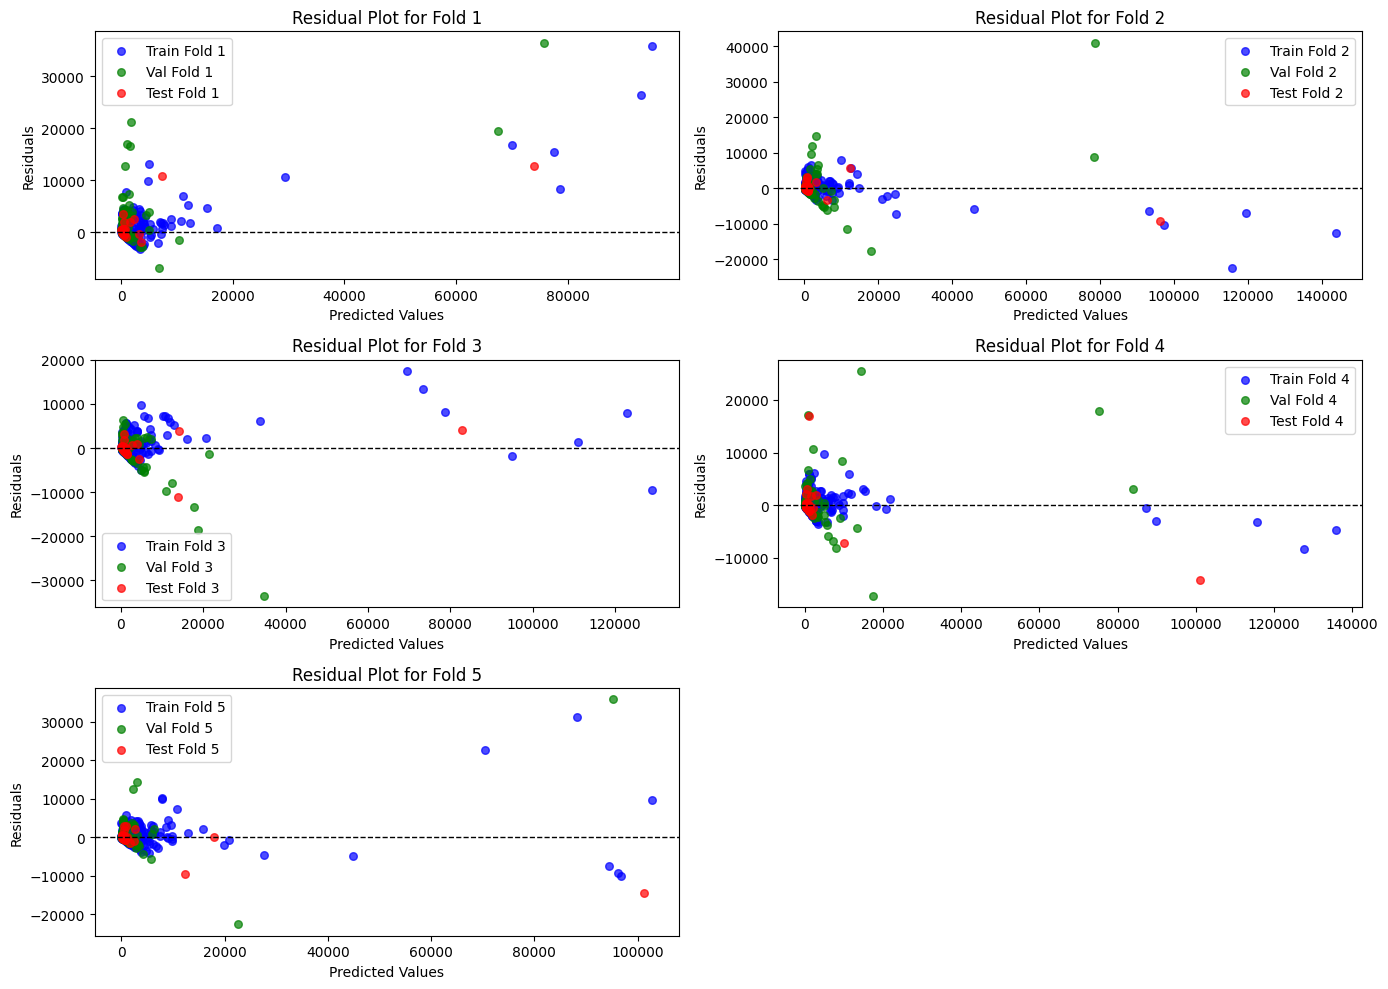

In [29]:
# Residual Plot:

# Plot the residuals for each fold (or average residuals) against the predicted values or the actual values to check for any patterns. A good model should show randomly scattered residuals with no clear pattern.

# What to Look For in the Residual Plot:
# Random Scatter: Ideally, the residuals should show a random scatter around the horizontal line at 0. This would suggest that the model's predictions are unbiased and not systematically under- or over-predicting.
# Patterns: If the residuals show any distinct patterns (e.g., a curve or a trend), this could indicate problems such as:
# Non-linearity: The model might not capture some non-linear relationships.
# Heteroscedasticity: The variance of residuals changes as the predicted values increase or decrease, which suggests that the model's performance is inconsistent across the range of values.
# Outliers: Large residuals (far from 0) can indicate outliers or data points that the model is struggling to predict.

plt.figure(figsize=(14, 10))

for i in range(len(results)):
    fold = results.loc[i, 'Fold']
    
    residuals_train = results.loc[i, 'Train Residuals']
    residuals_val = results.loc[i, 'Val Residuals']
    residuals_test = results.loc[i, 'Test Residuals']
    
    y_pred_train = results.loc[i, 'Train y_pred']
    y_pred_val = results.loc[i, 'Val y_pred']
    y_pred_test = results.loc[i, 'Test y_pred']
    
    residuals_train = [item[0] for sublist in residuals_train for item in sublist]
    residuals_val = [item[0] for sublist in residuals_val for item in sublist]
    residuals_test = [item[0] for sublist in residuals_test for item in sublist]
    
    y_pred_train = [item[0] for sublist in y_pred_train for item in sublist]
    y_pred_val = [item[0] for sublist in y_pred_val for item in sublist]
    y_pred_test = [item[0] for sublist in y_pred_test for item in sublist]

    plt.subplot(3, 2, i + 1)
    plt.scatter(y_pred_train, residuals_train, color='blue', label=f'Train Fold {fold}', alpha=0.7, s=30)
    plt.scatter(y_pred_val, residuals_val, color='green', label=f'Val Fold {fold}', alpha=0.7, s=30)
    plt.scatter(y_pred_test, residuals_test, color='red', label=f'Test Fold {fold}', alpha=0.7, s=30)

    plt.title(f"Residual Plot for Fold {fold}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

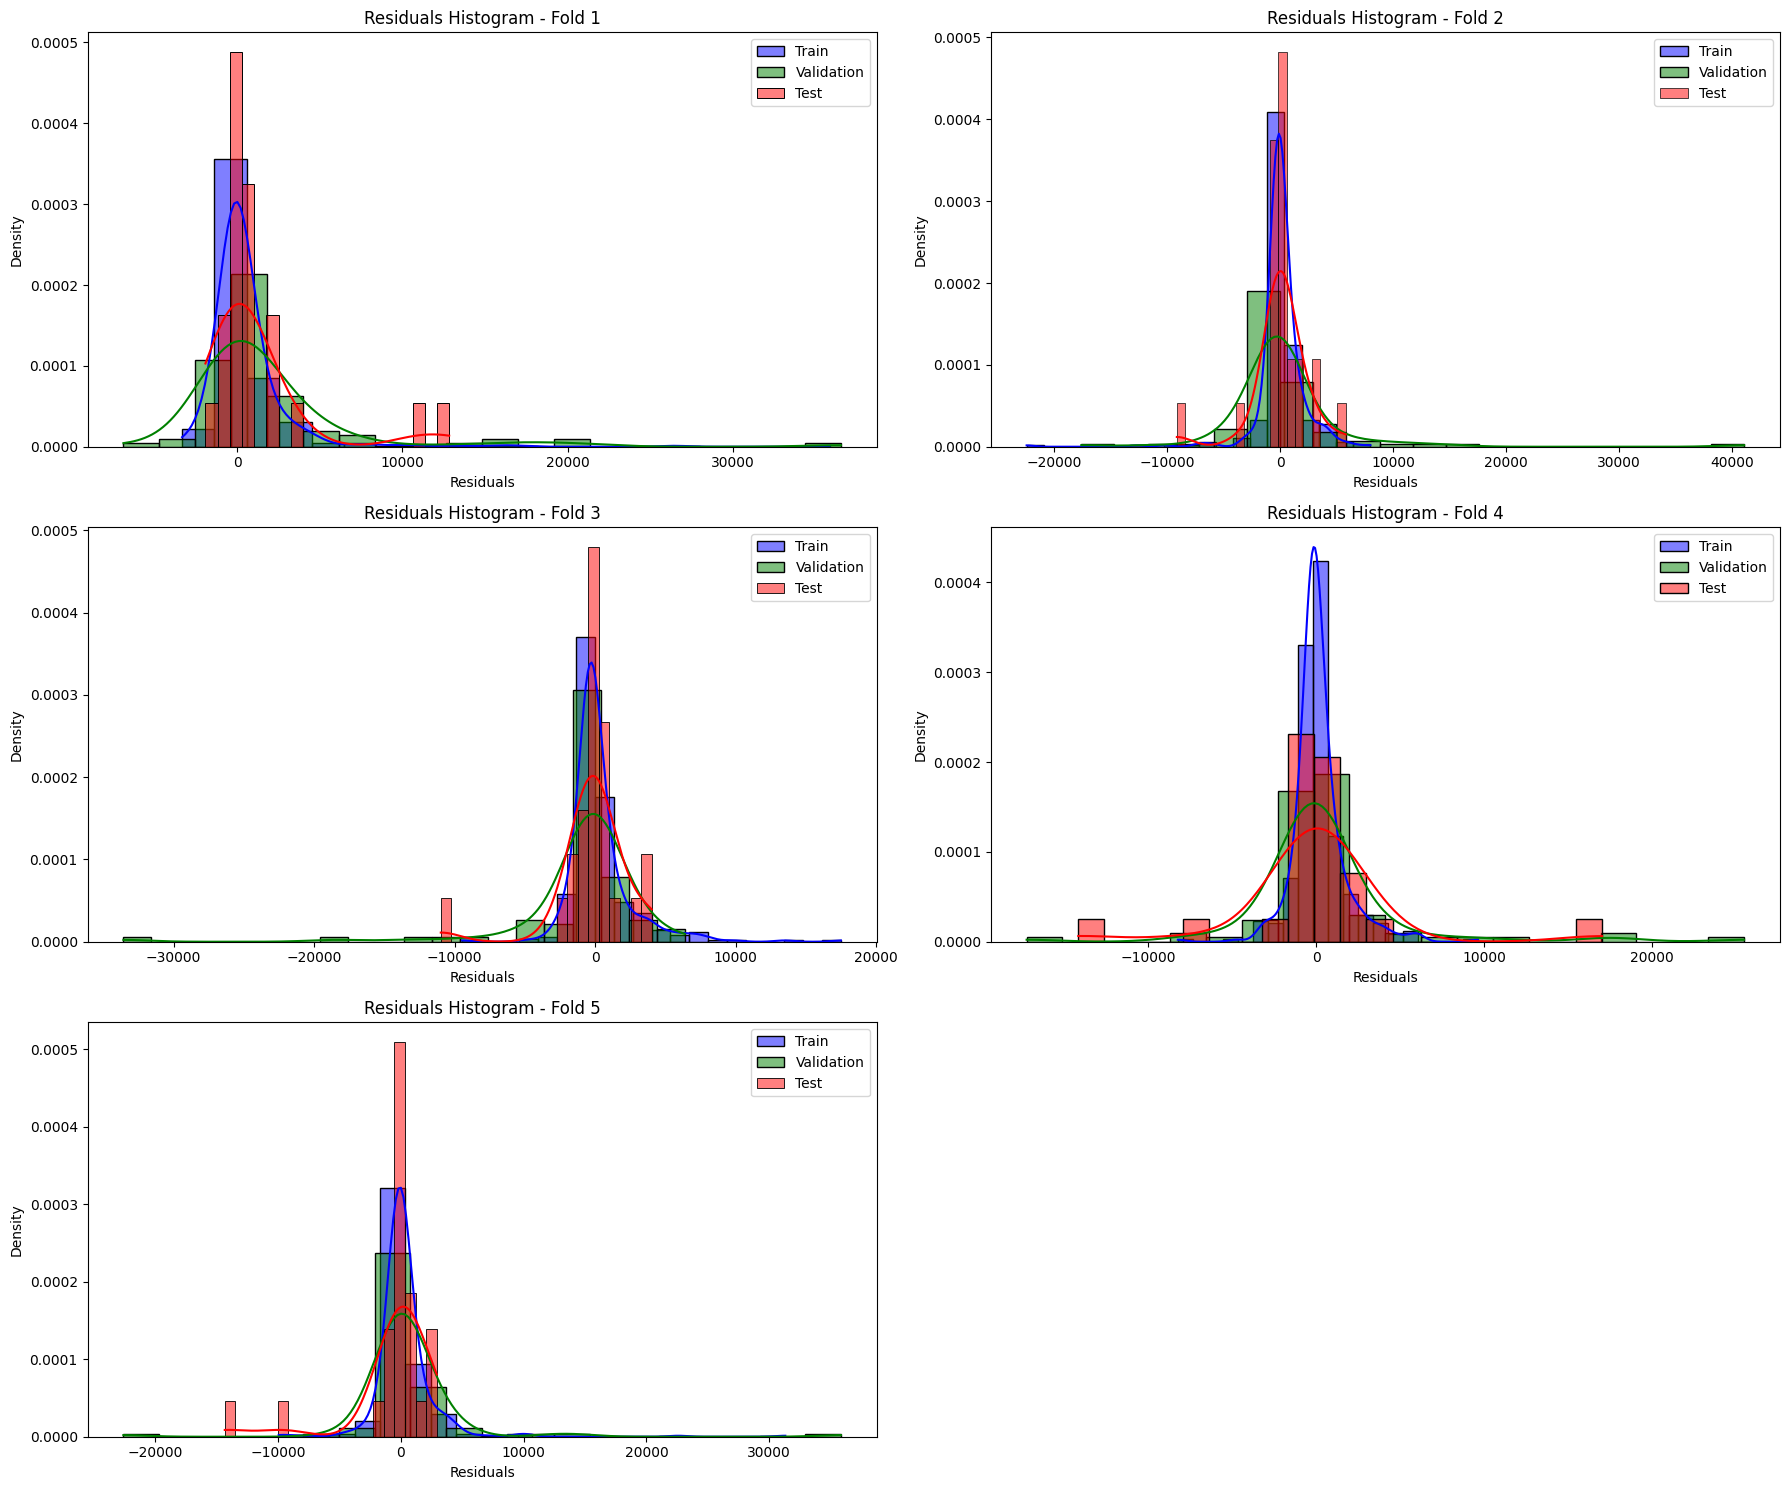

In [30]:
# Histogram of Residuals:

# Create histograms of residuals for training, validation, and testing data to check if they follow a normal distribution. This helps you understand if your model has any bias (e.g., consistently overpredicting or underpredicting).

# What to Look For in the Histogram of Residuals:
# Normal Distribution: Ideally, the residuals should follow a normal distribution (bell-shaped curve). This indicates that the model's errors are randomly distributed and unbiased.
# If the histogram is symmetric and centered around zero, it suggests that the model's predictions are neither systematically over- nor under-predicting.
# Skewness: If the residuals show skewness (i.e., the histogram is not symmetric), it might indicate a problem with the model's performance, such as:
# Positive Skew: The model might be under-predicting for larger values.
# Negative Skew: The model might be over-predicting for larger values.
# Outliers: Large residuals far from zero can suggest that the model is struggling to predict those data points. The histogram might show some outlier residuals (spikes in the tail) that could require further investigation.

plt.figure(figsize=(18, 15))

for i in range(len(results)):
    fold = results.loc[i, 'Fold']
    
    residuals_train = results.loc[i, 'Train Residuals']
    residuals_val = results.loc[i, 'Val Residuals']
    residuals_test = results.loc[i, 'Test Residuals']
    
    residuals_train = [item[0] for sublist in residuals_train for item in sublist]
    residuals_val = [item[0] for sublist in residuals_val for item in sublist]
    residuals_test = [item[0] for sublist in residuals_test for item in sublist]

    plt.subplot(3, 2, i + 1)

    sns.histplot(residuals_train, kde=True, color='blue', label='Train', bins=20, stat='density')
    sns.histplot(residuals_val, kde=True, color='green', label='Validation', bins=20, stat='density')
    sns.histplot(residuals_test, kde=True, color='red', label='Test', bins=20, stat='density')

    plt.title(f"Residuals Histogram - Fold {fold}")
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

### Training vs Test Performance

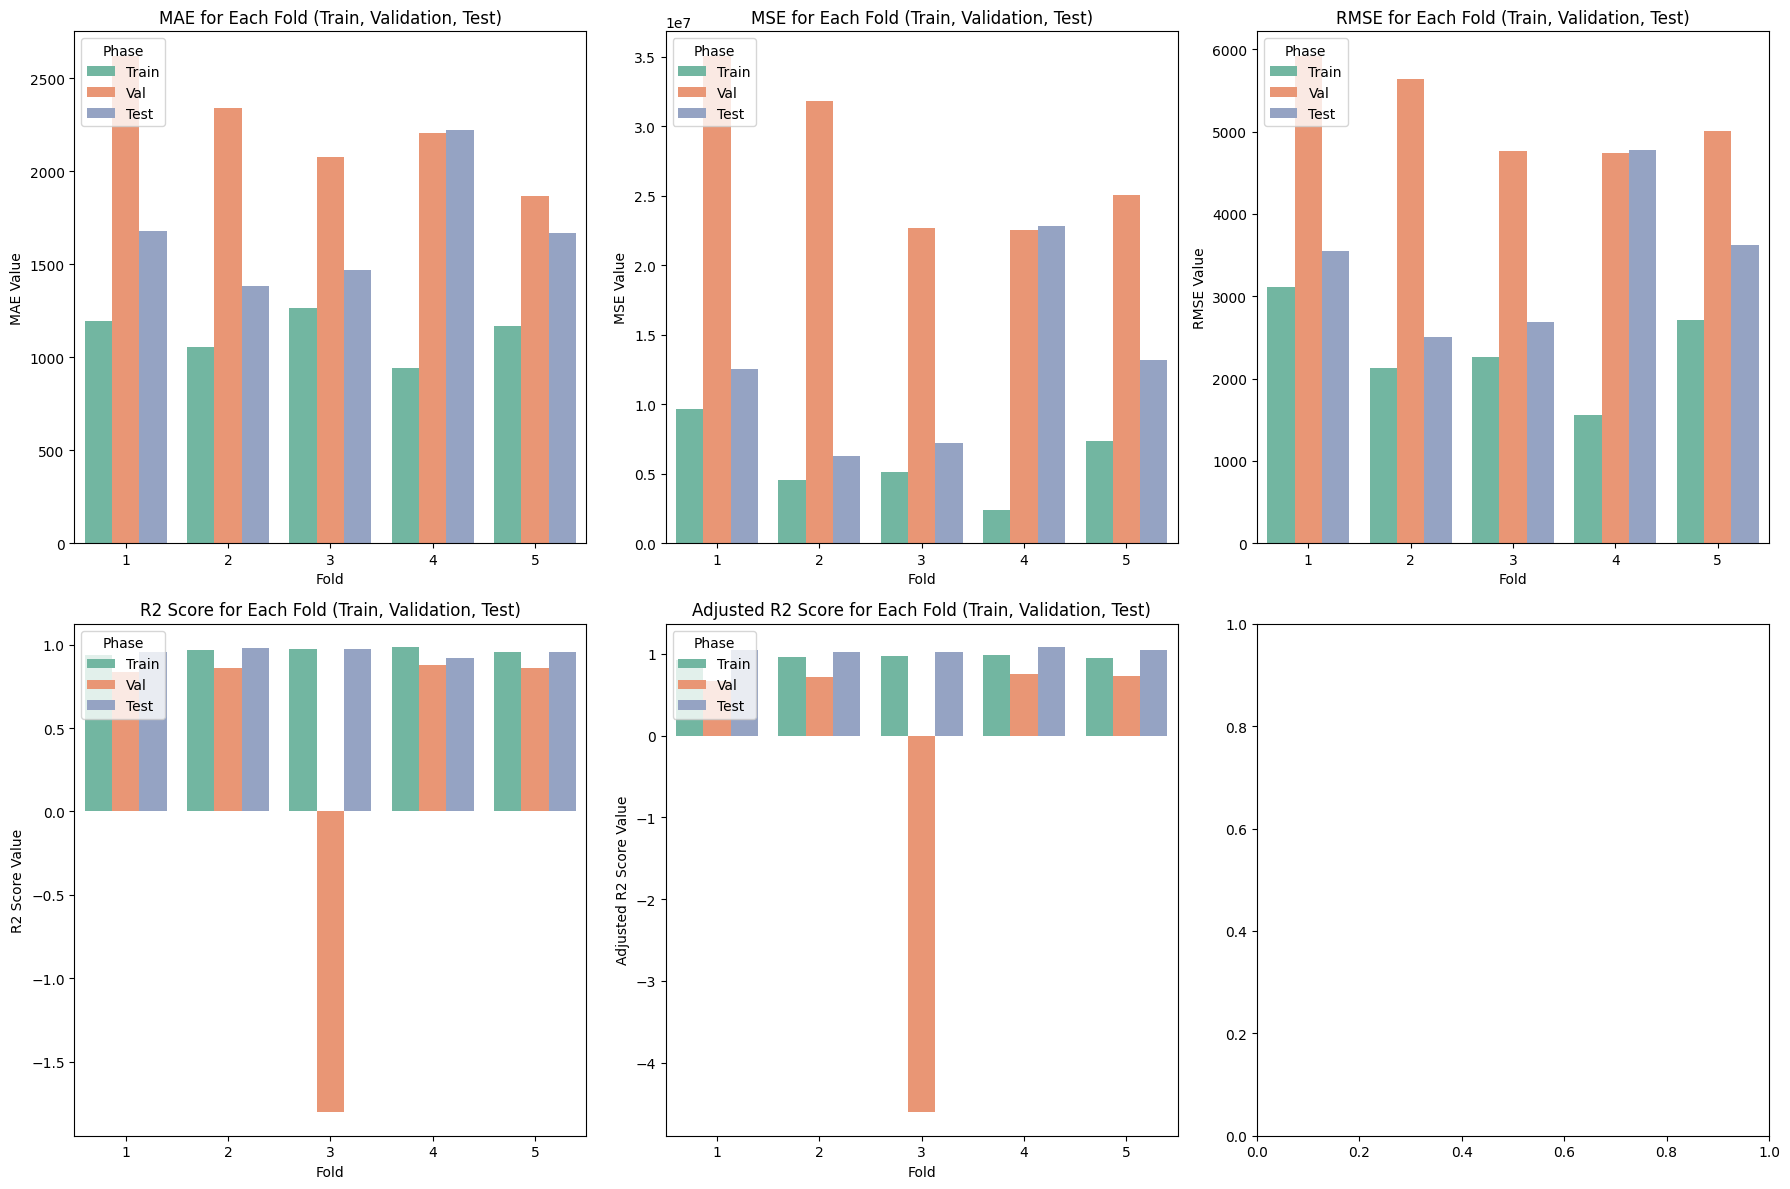

In [31]:
# Bar Plot of Train, Val, Test Metrics:
# Plot a bar graph showing the values of MAE, MSE, RMSE, and R2 for each fold’s training, validation, and testing phases. This is useful to see how the model is performing across these sets.

# What to Look For in the Bar Plot:
# Comparison Across Folds: You can compare the values of each metric for each fold, observing whether the model is consistently performing well across all folds.
# Performance on Train, Validation, and Test: The bar plot shows the performance of the model on training, validation, and test sets, helping to identify if the model is overfitting (i.e., if performance on the test set is much worse than on the training set).
# Different Metrics: You can easily see how the model's performance varies across different metrics (e.g., how MAE compares to RMSE or R2).

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes = axes.flatten()

for idx, metric in enumerate(metrics):
    data = []

    for i in range(len(results)):
        fold = results.loc[i, 'Fold']

        for phase in ['Train', 'Val', 'Test']:
            metric_value = results.loc[i, f'{phase} {metric}']
            data.append({
                'Fold': fold,
                'Phase': phase,
                'Value': metric_value
            })

    df_metrics = pd.DataFrame(data)

    sns.barplot(x='Fold', y='Value', hue='Phase', data=df_metrics, palette="Set2", ax=axes[idx])

    axes[idx].set_title(f"{metric} for Each Fold (Train, Validation, Test)")
    axes[idx].set_xlabel("Fold")
    axes[idx].set_ylabel(f"{metric} Value")
    axes[idx].legend(title='Phase', loc='upper left')

plt.tight_layout()
plt.show()

### Average of Metrics Across Folds

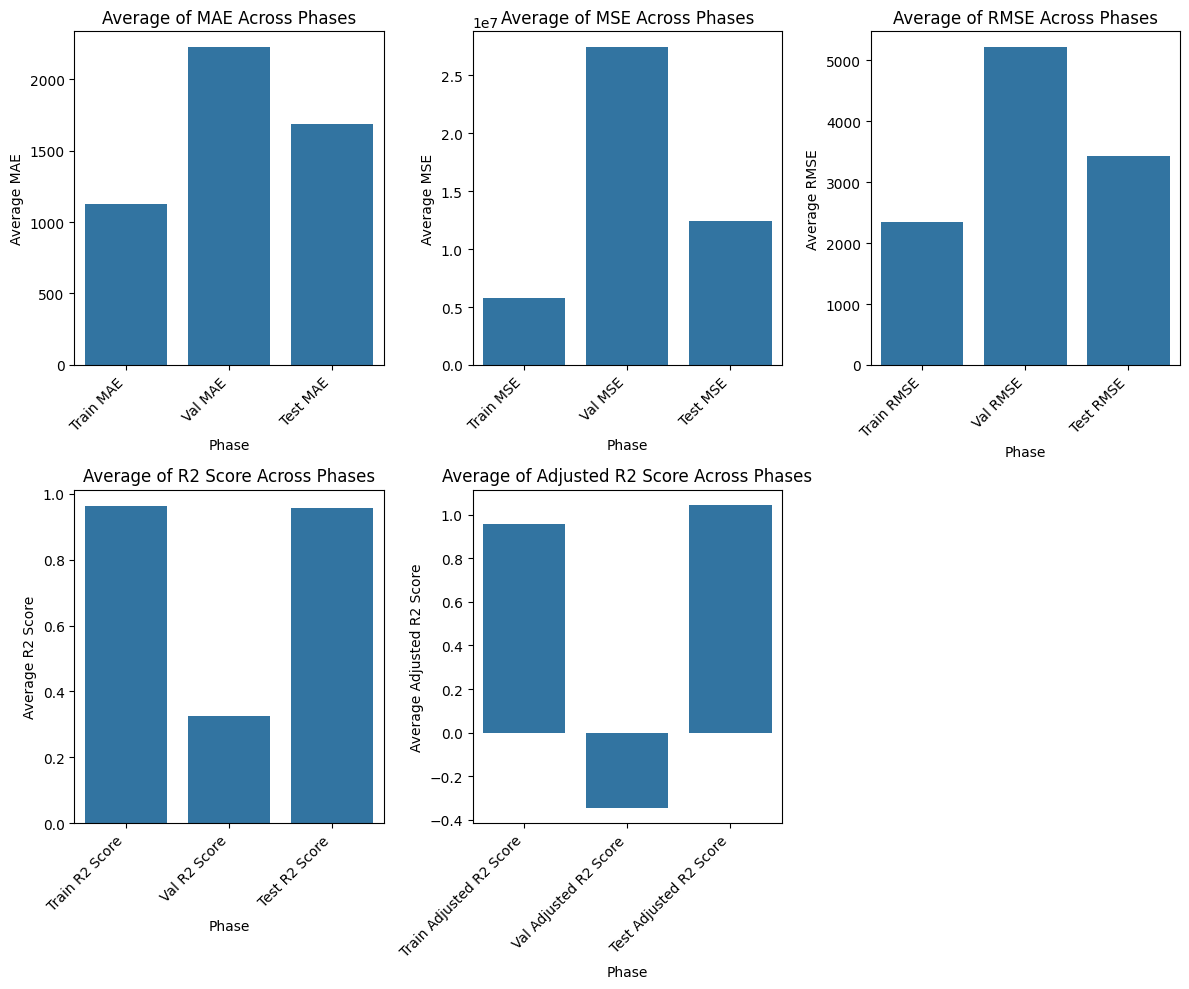

In [32]:
# Bar Plot of Average Metrics:
# Plot the average of MAE, MSE, RMSE, and R2 (both for training, validation, and testing) to provide an easy comparison of how well the model did overall.

# Summary of What to Look for:
# Consistency: The model should show similar performance across training, validation, and testing sets. Large discrepancies could indicate issues like overfitting or underfitting.
# Balance: For MAE, MSE, and RMSE, lower values are better, while for R2, higher values are better.
# Performance Across Phases: The model should perform similarly across Train, Validation, and Test sets. A major gap between Train and Test metrics indicates overfitting.

phases = ['Train', 'Val', 'Test']

plt.figure(figsize=(12, 10))

for i, metric in enumerate(metrics):
    avg_data = []
    
    for phase in phases:
        avg_value = results[f'{phase} {metric}'].mean()
        avg_data.append({
            'Metric-Phase': f'{phase} {metric}',
            'Average Value': avg_value
        })
    
    avg_df = pd.DataFrame(avg_data)
    
    plt.subplot(2, 3, i + 1)
    sns.barplot(x='Metric-Phase', y='Average Value', data=avg_df)
    
    plt.title(f'Average of {metric} Across Phases')
    plt.xlabel('Phase')
    plt.ylabel(f'Average {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()

### Heatmap of True and Predicted

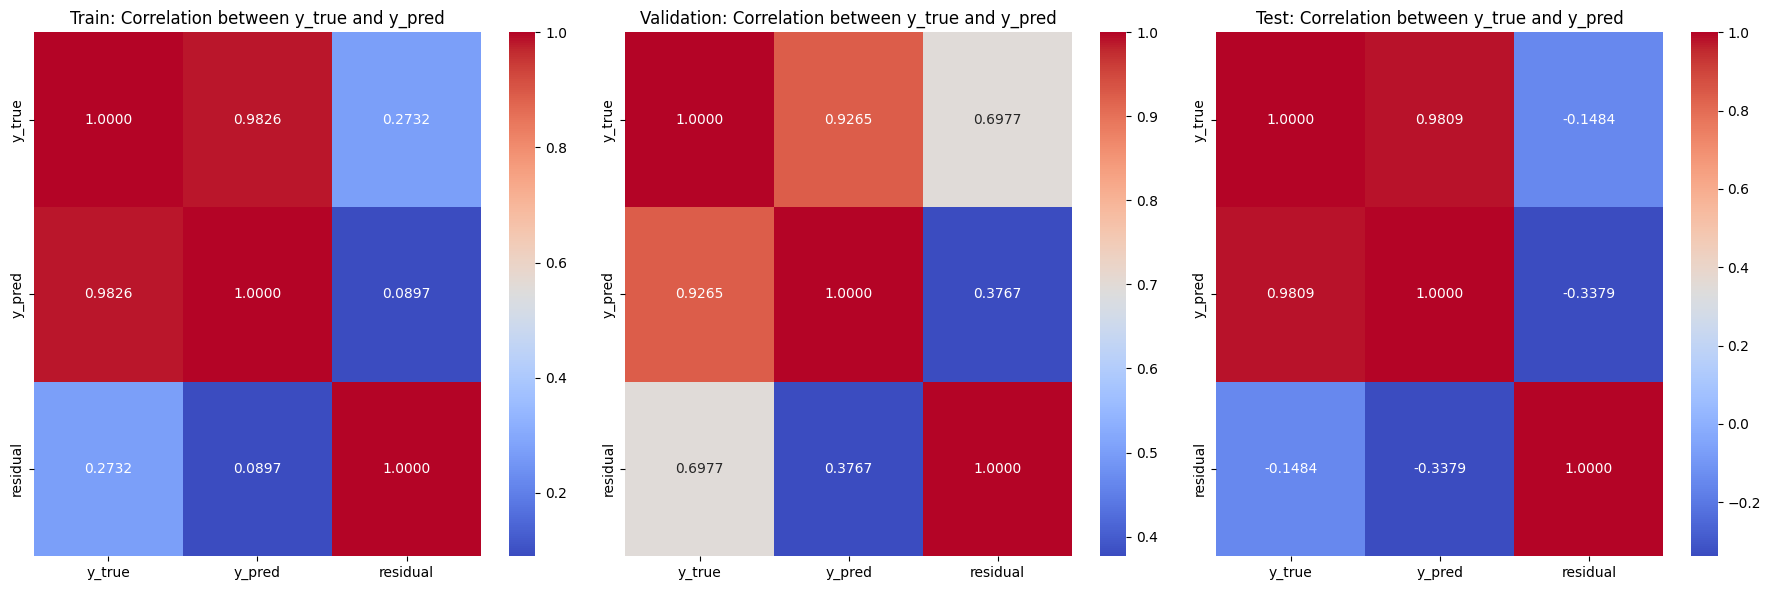

In [33]:
# Heatmap of y_true and y_pred:
# A heatmap can help visualize how predictions deviate from the true values. This is especially helpful when you have large datasets or outliers that might skew the results.

# What to Look For in the Heatmap:
# Diagonal Line (Correlation): A perfect prediction would be where the values of y_true and y_pred are very close, meaning the correlation between them should be near 1. If you see high correlation values (close to 1), it suggests that the model’s predictions are close to the true values.

# In an ideal case, for each dataset (train, val, test), you should see a strong positive correlation between y_true and y_pred.
# Deviations/Residuals: The residuals (the difference between y_true and y_pred) can show how much the predictions deviate from the true values. If the correlation is low, it might indicate that the model is consistently off in its predictions.

# High residuals indicate poor predictions, while low residuals indicate the model is close to predicting the true values.
# Data Skew: If the heatmap shows very low correlation (close to 0), that indicates random predictions with no discernible relationship to the true values. This may suggest problems with the model, such as underfitting.

# If the correlation is negative, that means the model is consistently predicting values in the opposite direction.
# Outliers: If you see large residuals (big differences between y_true and y_pred), this might indicate the presence of outliers. Outliers can heavily affect model performance and might need to be handled (e.g., removing or transforming them).

# Consistency Across Datasets: Ideally, the correlation between y_true and y_pred should be similar across training, validation, and test datasets. A large drop in correlation in the Test dataset could indicate overfitting where the model performs well on training data but poorly on unseen data.

# Ideal Scenario:
# Strong positive correlation (close to 1) for all datasets (train, validation, and test).
# Low residuals indicating the predictions are close to the actual values.
# No significant outliers or large residuals in the heatmap.


y_true_train = np.concatenate(results['Train y_true'].apply(lambda x: np.array(x).flatten()).values)
y_pred_train = np.concatenate(results['Train y_pred'].apply(lambda x: np.array(x).flatten()).values)

y_true_val = np.concatenate(results['Val y_true'].apply(lambda x: np.array(x).flatten()).values)
y_pred_val = np.concatenate(results['Val y_pred'].apply(lambda x: np.array(x).flatten()).values)

y_true_test = np.concatenate(results['Test y_true'].apply(lambda x: np.array(x).flatten()).values)
y_pred_test = np.concatenate(results['Test y_pred'].apply(lambda x: np.array(x).flatten()).values)

train_df = pd.DataFrame({'y_true': y_true_train, 'y_pred': y_pred_train})
val_df = pd.DataFrame({'y_true': y_true_val, 'y_pred': y_pred_val})
test_df = pd.DataFrame({'y_true': y_true_test, 'y_pred': y_pred_test})

train_df['residual'] = train_df['y_true'] - train_df['y_pred']
val_df['residual'] = val_df['y_true'] - val_df['y_pred']
test_df['residual'] = test_df['y_true'] - test_df['y_pred']

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt='.4f', cbar=True)
plt.title('Train: Correlation between y_true and y_pred')

plt.subplot(1, 3, 2)
sns.heatmap(val_df.corr(), annot=True, cmap='coolwarm', fmt='.4f', cbar=True)
plt.title('Validation: Correlation between y_true and y_pred')

plt.subplot(1, 3, 3)
sns.heatmap(test_df.corr(), annot=True, cmap='coolwarm', fmt='.4f', cbar=True)
plt.title('Test: Correlation between y_true and y_pred')

plt.tight_layout()
plt.show()

# Saving Our Hyperparameterized Model with Cross Validation

In [34]:
torch.save(best_model.state_dict(), 'DeepCorn_Best_Model_optimized.pth')

# Interpretability

In [35]:
best_model = DeepCornModelV2(
    input_dim=X_train_val.shape[1],
    hidden_units=best_params['hidden_units'],
    num_layers=best_params['num_layers'],
    dropout_rate=best_params['dropout_rate']
).to(device)

best_model.load_state_dict(torch.load('DeepCorn_Best_Model_optimized.pth', weights_only = True))
best_model.eval()

DeepCornModelV2(
  (network): Sequential(
    (0): Linear(in_features=47, out_features=485, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.40767236375600413, inplace=False)
    (3): Linear(in_features=485, out_features=485, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.40767236375600413, inplace=False)
    (6): Linear(in_features=485, out_features=485, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.40767236375600413, inplace=False)
    (9): Linear(in_features=485, out_features=485, bias=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.40767236375600413, inplace=False)
    (12): Linear(in_features=485, out_features=1, bias=True)
  )
)

In [36]:
import shap

idx = 0

X_test_tensor = X_test.clone().detach().float().to(device)

explainer = shap.DeepExplainer(best_model, X_test_tensor)
shap_values = explainer.shap_values(X_test_tensor, ranked_outputs=False)
shap_values = shap_values[idx][:, :, 0]

In [37]:
print("SHAP Shape:", shap_values.shape)  
print("X_test Shape:", X_test.shape)

SHAP Shape: (25, 47)
X_test Shape: torch.Size([25, 47])


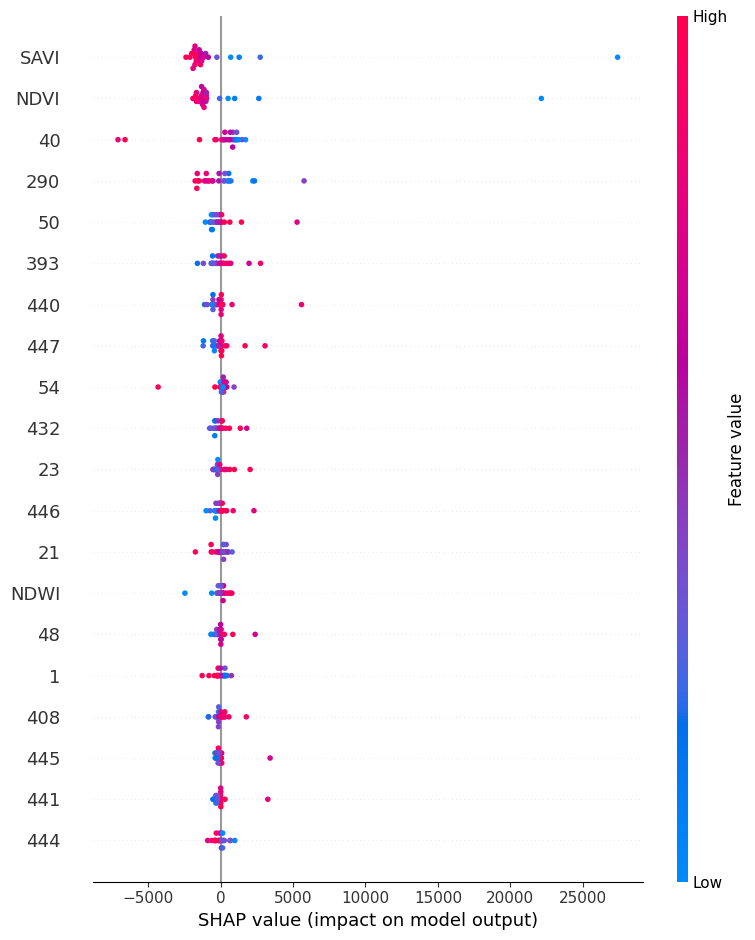

In [38]:
shap.summary_plot(shap_values, X_test, feature_names=cols)

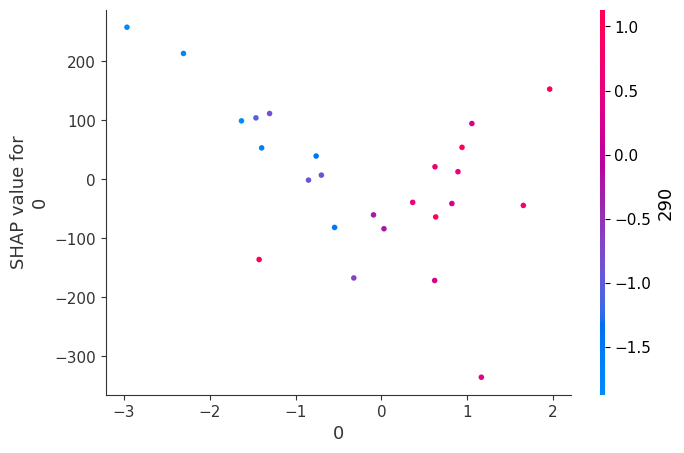

In [39]:
X_test_numpy = X_test.cpu().detach().numpy()
shap.dependence_plot(idx, shap_values, X_test_numpy, feature_names=cols)

In [40]:
shap.initjs()

shap.force_plot(
    explainer.expected_value[0], 
    shap_values[idx], 
    pd.DataFrame(X_test_numpy, columns=cols).iloc[idx].values,
    feature_names=cols
)

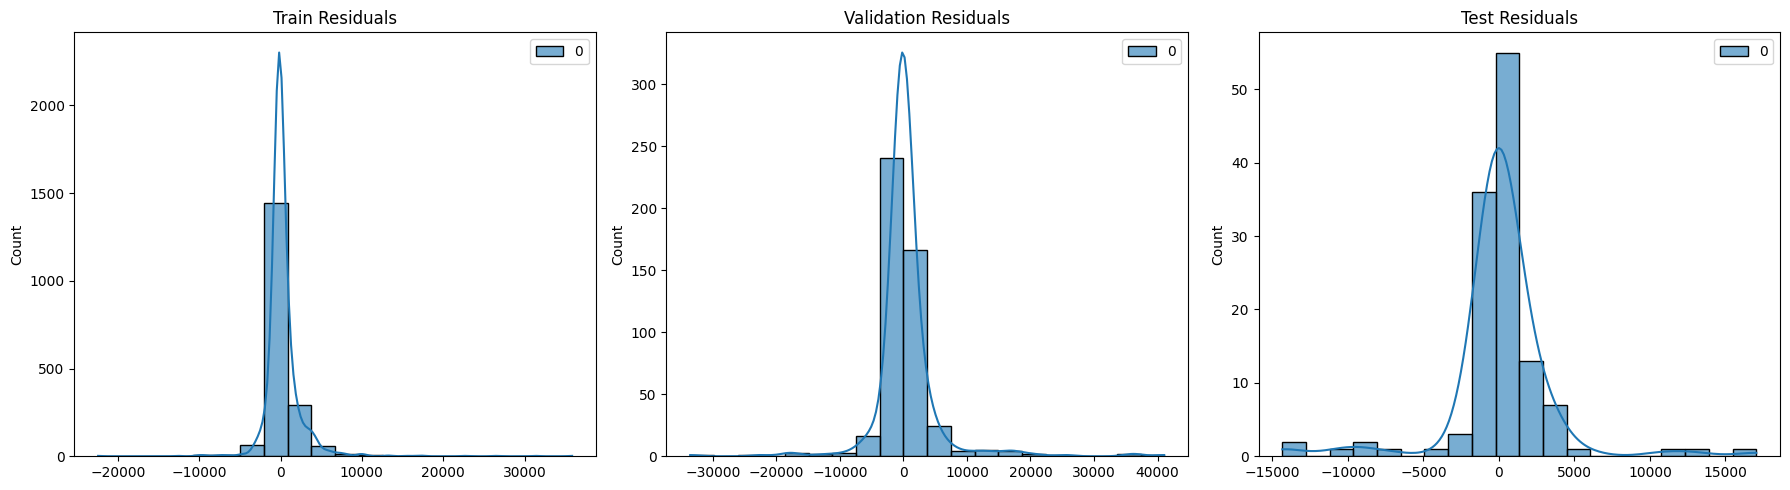

In [41]:
train_residuals = np.concatenate(np.concatenate(results['Train y_true'])) - np.concatenate(np.concatenate(results['Train y_pred']))
val_residuals = np.concatenate(np.concatenate(results['Val y_true'])) - np.concatenate(np.concatenate(results['Val y_pred']))
test_residuals = np.concatenate(np.concatenate(results['Test y_true'])) - np.concatenate(np.concatenate(results['Test y_pred']))

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_residuals, kde=True, bins=20, color='blue', alpha=0.6)
plt.title("Train Residuals")

plt.subplot(1, 3, 2)
sns.histplot(val_residuals, kde=True, bins=20, color='orange', alpha=0.6)
plt.title("Validation Residuals")

plt.subplot(1, 3, 3)
sns.histplot(test_residuals, kde=True, bins=20, color='green', alpha=0.6)
plt.title("Test Residuals")

plt.tight_layout()
plt.show()

,name,feature_importance,cumulative_importance
46,SAVI,0.349050,0.349050
44,NDVI,0.198317,0.547367
10,40,0.154334,0.701701
23,290,0.101567,0.803268
14,54,0.061852,0.865120
3,21,0.048709,0.913830
37,440,0.038582,0.952412
41,445,0.032423,0.984835
26,393,0.028901,1.013736
13,50,0.025829,1.039564


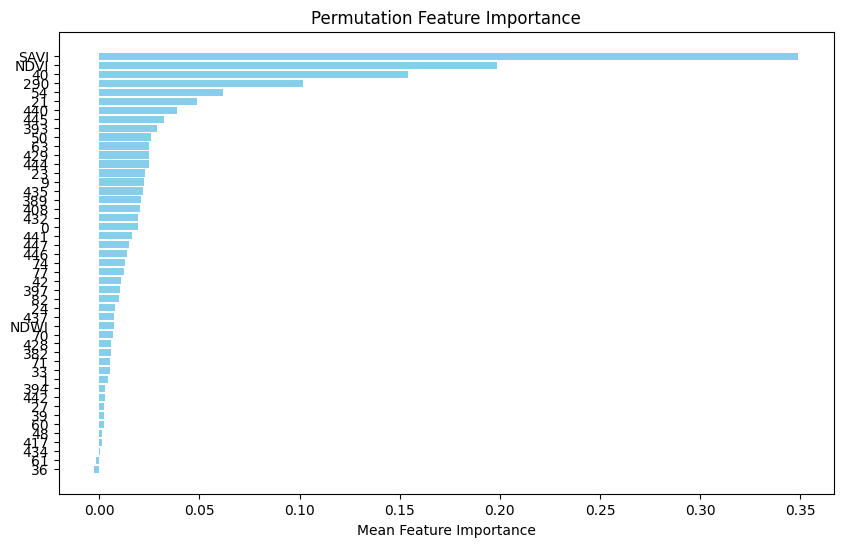

In [42]:
class SklearnWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self):
        return self.model

    def predict(self, X):
        device = next(self.model.parameters()).device
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        self.model.eval()
        with torch.no_grad():
            return self.model(X_tensor).cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

wrapped_model = SklearnWrapper(best_model)

result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=20)

importance_df = pd.DataFrame({
    'name': cols,
    'feature_importance': result.importances_mean
})

importance_df = importance_df.sort_values(by='feature_importance', ascending=False)

importance_df['cumulative_importance'] = importance_df['feature_importance'].cumsum()

display(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['name'], importance_df['feature_importance'], color='skyblue')
plt.xlabel("Mean Feature Importance")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [43]:
importance_df[importance_df['feature_importance'] <= 0]['name'].values

array(['61', '36'], dtype=object)

In [46]:
from flask import Flask, request, jsonify

  Using cached flask-3.1.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached flask-3.1.0-py3-none-any.whl (102 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
Note: you may need to restart the kernel to use updated packages.


In [47]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [50]:
df = df.drop(['vomitoxin_ppb', 'mode', 'target_cluster', 'sensor_cluster', 'Anomaly'], axis=1)

In [52]:
cols_to_drop = ['302', '258', '368', '327', '44', '346', '269', '354', '279',
       '314', '99', '420', '29', '292', '83', '254', '295', '263', '231',
       '243', '351', '6', '25', '248', '2', '350', '390', '13', '247',
       '85', '330', '443', '177', '160', '276', '31', '14', '94', '221',
       '92', '58', '306', '69', '316', '339', '373', '5', '81', '19',
       '15', '228', '234', '317', '321', '203', '436', '240', '55', '214',
       '187', '226', '84', '207', '355', '259', '277', '172', '419',
       '229', '357', '233', '291', '95', '288', '72', '383', '217', '79',
       '192', '105', '227', '137', '206', '150', '52', '264', '267',
       '304', '168', '224', '3', '7', '237', '186', '96', '379', '225',
       '133', '157', '104', '209', '245', '158', '148', '152', '201',
       '239', '167', '26', '164', '404', '132', '198', '271', '301', '93',
       '161', '169', '100', '174', '112', '204', '212', '359', '281',
       '166', '235', '238', '141', '268', '232', '162', '103', '208',
       '86', '154', '241', '274', '173', '10', '362', '107', '51', '143',
       '183', '219', '87', '252', '210', '244', '163', '216', '145',
       '193', '110', '146', '117', '123', '101', '223', '149', '184', '4',
       '114', '122', '236', '230', '97', '119', '147', '57', '127', '116',
       '59', '175', '118', '109', '205', '28', '12', '189', '185', '190',
       '142', '128', '215', '124', '182', '179', '125', '181', '222',
       '180', '151', '115', '131', '120', '144', '111', '200', '126',
       '73', '155', '138', '197', '165', '278', '308', '171', '108',
       '153', '106', '8', '130', '188', '250', '129', '156', '213', '170',
       '194', '140', '159', '134', '139', '121', '11', '195', '136',
       '113', '135', '102', '56', '298', '344', '47', '340', '421', '332', '286', '251', '41', '403',
       '349', '66', '415', '307', '328', '309', '303', '78', '313', '342',
       '34', '402', '261', '312', '273', '430', '367', '385', '305',
       '438', '386', '256', '293', '326', '375', '320', '384', '335',
       '387', '300', '374', '17', '211', '285', '257', '255', '220',
       '401', '334', '265', '90', '45', '262', '294', '369', '270', '88',
       '352', '242', '376', '196', '68', '289', '176', '253', '297',
       '199', '412', '22', '284', '266', '65', '246', '280', '272', '283',
       '311', '218', '178', '191', '338', '260', '282', '331', '202',
       '310', '287', '98', '43', '371', '348', '396', '62', '337', '89', '67', '405', '365',
            '53', '80', '329', '64', '16', '325', '361', '360', '347', '343',
            '391', '91', '364', '18', '353', '275', '345', '323', '324', '333',
            '341', '370', '363', '322', '356', '296', '319', '318', '249',
            '20', '299', '315', '35', '372', '427', '413', '422', '414', '398', '426', '336','392', '388', '433', '418',
             '411', '409', '424', '439', '38', '423', '406', '46', '410', '76', '395'
                               , '400', '407', '366', '416', '381', '358', '377', '378', '399', 
                               '380', '32', '49', '75', '30', '37', '425', '431']

In [53]:
df = df.drop(cols_to_drop, axis=1)
df

,0,1,9,21,23,24,27,33,36,39,...,440,441,442,444,445,446,447,NDVI,NDWI,SAVI
0,-1.190358,-1.367662,-1.261091,-1.363434,-1.523116,-0.952130,-1.371861,-1.282617,-0.889075,-1.286857,...,-0.698911,-0.910414,-0.660256,-0.814301,-0.808859,-1.068500,-0.686713,0.255041,-0.907355,-0.093526
1,-1.202511,-1.029215,-1.698937,-2.039964,-2.108954,-1.684228,-1.885733,-2.066255,-1.766825,-2.302592,...,-1.169091,-1.161901,-1.162023,-1.133386,-1.159954,-1.015031,-0.986322,0.750090,-4.084140,-0.088937
2,-1.208646,-1.559844,-1.299557,-1.066430,-1.525168,-1.924079,-2.191238,-1.911226,-1.448298,-1.607657,...,-2.730370,-2.126975,-2.049602,-2.055077,-2.056347,-2.172351,-2.251401,-2.236660,-0.535062,-2.884617
3,1.243694,1.285404,1.354407,1.759372,1.928566,2.440080,1.464054,2.223945,2.218271,2.517676,...,0.577961,0.907243,1.071292,1.147499,1.127894,0.709068,1.532140,-1.373434,0.693641,-1.023318
4,-0.920165,-0.735059,-1.021395,-0.986350,-0.862211,-0.974516,-0.726080,-0.947196,-1.103525,-0.524061,...,-0.339492,-0.221483,-0.484760,-0.502624,-0.326697,-0.389917,-0.361344,0.304585,-0.109763,0.278426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.029445,-0.170559,-0.146501,-0.742601,-0.572517,-0.437849,-0.601703,-0.765654,-0.829054,-0.167512,...,-0.901705,-0.910343,-1.253205,-0.588580,-1.009967,-0.263803,-0.865861,0.412235,-0.370078,0.257272
496,-1.696274,-1.365537,-0.763811,-1.109850,-1.595091,-0.933279,-0.992649,-1.890208,-1.311490,-1.251600,...,-0.161729,0.332229,0.208800,0.242106,-0.201217,-0.072504,-0.018750,1.595437,-1.761834,1.451216
497,0.985949,1.406483,0.756593,0.663375,0.742060,0.572124,0.915338,0.556936,0.454730,0.365078,...,0.596528,0.343305,0.328929,0.145278,0.277233,0.418433,0.588040,-0.182471,-0.010574,-0.129715
498,0.574206,0.373679,0.857039,0.813613,0.644824,0.173176,0.482993,0.452943,0.546559,-0.042181,...,0.863729,0.797180,0.769416,0.709354,0.649048,0.956929,0.966749,-0.002955,-0.906601,0.149967
